## HUFF MODEL SIMULATION
* Attractiveness Factor: Multiply the attractiveness of the destination by some constant.
* Accessibility Factor: Divide by some function of the distance between the origin and destination.
* Alpha Parameter: Alpha is typically a parameter that adjusts the sensitivity of the model to distance.

Link to source: https://pro.arcgis.com/en/pro-app/latest/tool-reference/business-analyst/understanding-huff-model.htm

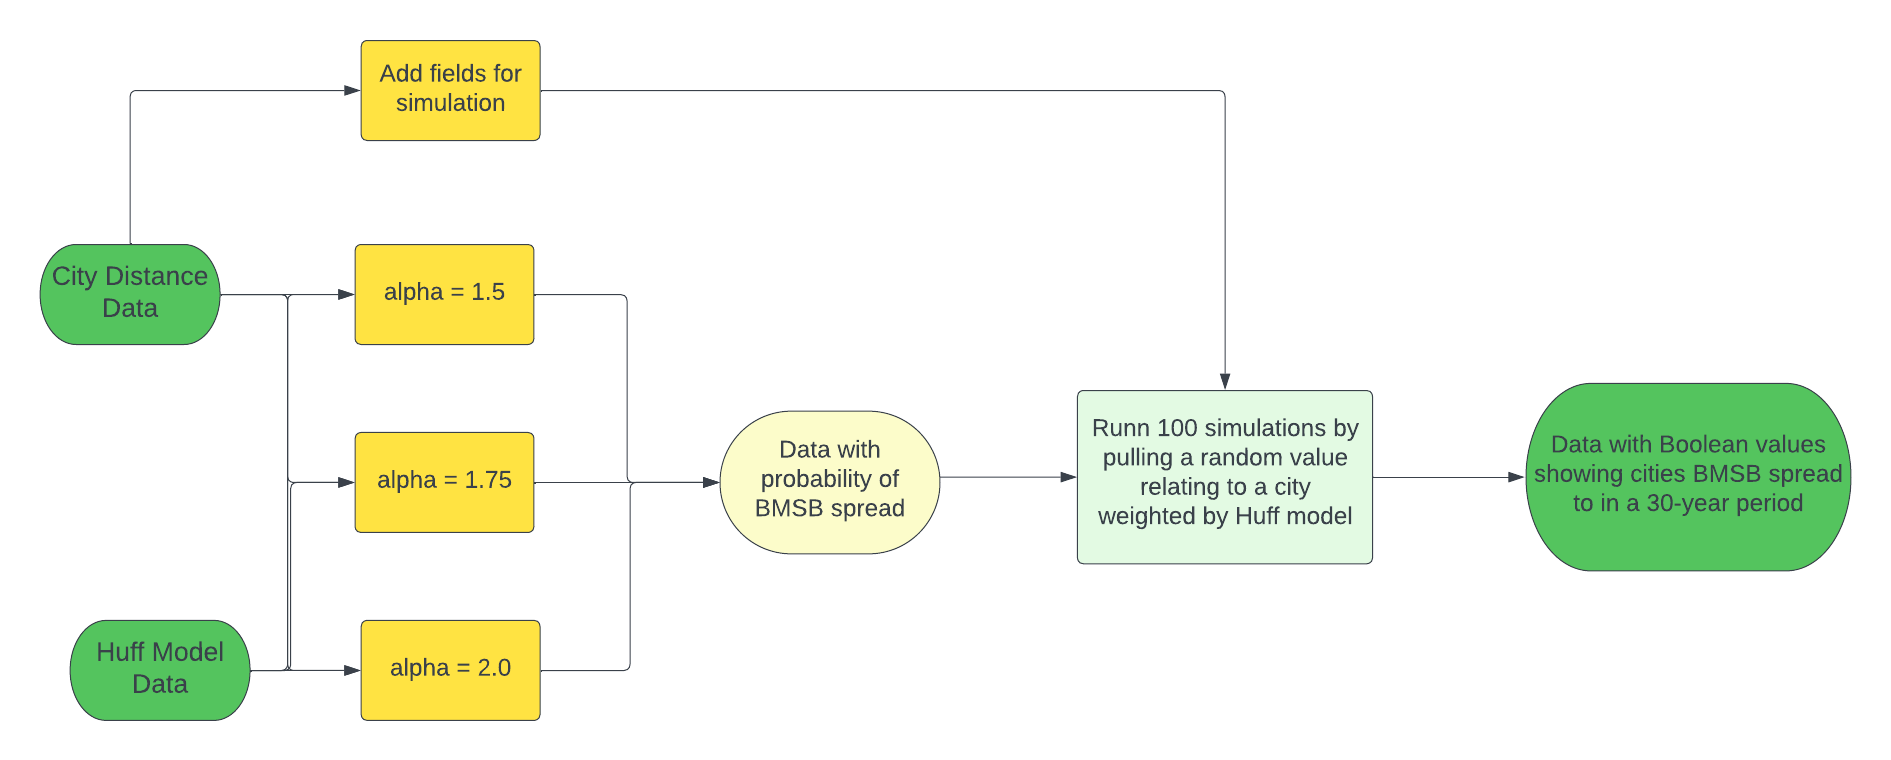

In [11]:
# Set the path to the image file
image_path = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\Deliverables\Simulation.png"

# Display the image
Image(image_path)

In [2]:
# Library for data manipulation and analysis
import pandas as pd

# Library for working with ArcGIS tools and functionalities
import arcpy
import arcgis

# Libraries for working with PostgreSQL
import psycopg2
from psycopg2 import sql

# Library for handling JSON data
import json

# Library for making HTTP requests and interacting with web services
import requests

# Library for interacting with the operating system, managing file paths, and executing system commands
import os

# Library for handling warnings generated during code execution
import warnings

# Library for displaying images in Jupyter Notebooks
from IPython.display import Image

# Library for generating random numbers
import random

# Library for handling zip files and working with IO streams
import zipfile
import io

# Library for working with dates
from datetime import date

import urllib.request

### Path to FGDB 

In [3]:
#path to local database
file_gdb = r"F:\1. UMN MGIS\1. Semesters\4th Semester\1. ArcGIS II\4. Project\ArcPro Files\ArcII_Final Project\ArcII_Final Project.gdb"

### Calculating Transition Probability  

In [27]:
# Define paths to tables and feature classes
City_Distance_Table = os.path.join(file_gdb, "MN_Cities_Distance_Table")
BMSB_PointsData_SJ = os.path.join(file_gdb, "BMSB_PointsData_SJ")
MN_Cities_15 = os.path.join(file_gdb, "MN_Cities_15")

In [28]:
# Function to calculate Huff model
def calculate_huff(fc, fields, alpha, scalar):
    # Initialize denominator for Huff model
    huff_denominator = 0
    
    # Search cursor to iterate through feature class
    with arcpy.da.SearchCursor(fc, fields) as cursor:
        for row in cursor:
            city1_pop = row[3]
            city2_pop = row[4]
            near_dist = row[2]
            
            # Calculate numerator for Huff model
            huff_numerator = (city1_pop * city2_pop) / (near_dist ** alpha)
            
            # Add numerator to denominator
            huff_denominator += huff_numerator
            
        # Update cursor to calculate and assign probability of transfer for city pairs
        with arcpy.da.UpdateCursor(fc, fields) as cursor:
            for row in cursor:
                city1_pop = row[3]
                city2_pop = row[4]
                near_dist = row[2]
        
                # Calculate Huff value and scale it
                huff_numerator = (city1_pop * city2_pop) / (near_dist ** alpha)
                row[5] = scalar * (huff_numerator / huff_denominator)
                cursor.updateRow(row)

### Calculating Huff model with varrying alpha values

In [32]:
# Apha 1.5

fc = 'MN_Cities_Distance_Table'
fields = ['City_1', 'City_2', 'Near_Dist', 'City_1_POP', 'City_2_POP', 'Trans_Prob_15']
alpha = 1.5
scalar = 25

In [33]:
# Call the function to calculate Huff model
calculate_huff(fc, fields, alpha, scalar)
print('Calculation of Huff model with apha 1.5 is completed.')

Calculation of Huff model with apha 1.5 is completed.


In [34]:
# Apha 1.75

fc = 'MN_Cities_Distance_Table'
fields = ['City_1', 'City_2', 'Near_Dist', 'City_1_POP', 'City_2_POP', 'Trans_Prob_175']
alpha = 1.75
scaler_k = 25

# Call the function to calculate Huff model
calculate_huff(fc, fields, alpha, scalar)
print('Calculation of Huff model with apha 1.75 is completed.')

Calculation of Huff model with apha 1.75 is completed.


In [39]:
# Main code
fc = 'MN_Cities_Distance_Table'
fields = ['City_1', 'City_2', 'Near_Dist', 'City_1_POP', 'City_2_POP', 'Trans_Prob_2']
alpha = 2
scaler_k = 25

# Call the function to calculate Huff model
calculate_huff(fc, fields, alpha, scalar)
print('Calculation of Huff model with apha 2 is completed.')

Calculation of Huff model with apha 2 is completed.


## Simulating the Spread of BMSB
* We are using Simulation Loop to iterate over each simulation from 0 to num_simulations - 1 (100 in this case)
* Our seed or starting city is Minneapolis - Results chnage if we start with St. Paul or any other city with high reported BMSB sightings 
* We are using:
** 14 simulation steps, basically 14 discrete time steps or iterations
** Presence and Absence Lists to retrieve cities with BMSB presence and absence 
** Update Spread function to update spread in every single timestep

In [37]:
def simulateSpread(city_fc, huff_fc, city_fields, huff_fields, num_simulations, starting_city, timestep, file_gdb):
    
    # Iterate over the number of simulations
    for i in range(num_simulations):
        SimCol = 'BMSB_Sim' + str(i)
        
        # Populate simulation column with seed city
        city_fields.append(SimCol)

        with arcpy.da.UpdateCursor(city_fc, city_fields) as cursor:
            for row in cursor:
                if row[0] == starting_city:
                    row[2] = 1
                else:
                    row[2] = 0
                cursor.updateRow(row)

        # Perform spread simulation for each timestep
        for k in range(timestep):
            presence_list = []
            absence_list = []

            # Search cursor to iterate through feature class
            with arcpy.da.SearchCursor(city_fc, city_fields) as cursor:
                for row in cursor:
                    # Check if city is present or absent
                    if row[2] == 1:
                        presence_list.append(row[0])
                    else:
                        absence_list.append(row[0])
            
            spread_list = [] 
    
            # Search cursor to iterate through feature class
            with arcpy.da.SearchCursor(huff_fc, huff_fields) as cursor:
                for row in cursor:
                    # Check if cities in the presence list
                    if row[0] in presence_list:
                        dest_city = row[1]
                    elif row[1] in presence_list:
                        dest_city = row[0]
                    else:
                        continue

                    trans_prob = row[2]

                    # Spread to cities in the absence list based on transition probability
                    if dest_city in absence_list:
                        if trans_prob >= random.random():
                            spread_list.append(dest_city)
            
            # Update spread in a single timestep
            with arcpy.da.UpdateCursor(city_fc, city_fields) as cursor:
                for row in cursor:
                    if row[0] in spread_list:
                        row[2] = 1
                        cursor.updateRow(row)
                        
            print("Simulation " + str(i) + " | Timestep " + str(k) + ": BMSB spread to " + str(len(spread_list)) + " location(s): " + str(spread_list))
                        
        city_fields.remove(SimCol)
            
        print('Simulation', i, 'Complete')

    print("All Simulations Complete")

In [38]:
# Huff Model 1: Alpha = 1.5

simulateSpread(
    city_fc = 'MN_Cities_15', 
    huff_fc = 'MN_Cities_Distance_Table', 
    city_fields = ['City','SUM_Population'], 
    huff_fields = ['City_1','City_2','Trans_Prob_15'], 
    num_simulations = 100, 
    starting_city = 'Minneapolis', 
    timestep = 30, 
    file_gdb = file_gdb
)

Simulation 0 | Timestep 0: BMSB spread to 8 location(s): ['Brooklyn Park', 'Little Canada', 'Maple Grove', 'New Hope', 'Oakdale', 'Robbinsdale', 'Saint Louis Park', 'Saint Paul']
Simulation 0 | Timestep 1: BMSB spread to 12 location(s): ['Blaine', 'Bloomington', 'Burnsville', 'Circle Pines', 'Crystal', 'Dellwood', 'Edina', 'Edina', 'Fridley', 'Mendota Heights', 'Savage', 'Woodbury']
Simulation 0 | Timestep 2: BMSB spread to 9 location(s): ['Oak Grove', 'Eden Prairie', 'Plymouth', 'Gaylord', 'Hilltop', 'Vadnais Heights', 'Plymouth', 'Roseville', 'South Saint Paul']
Simulation 0 | Timestep 3: BMSB spread to 13 location(s): ['Apple Valley', 'Columbia Heights', 'Columbia Heights', 'Coon Rapids', 'Coon Rapids', 'Dundas', 'Minnetonka', 'Farmington', 'Inver Grove Heights', 'Lauderdale', 'White Bear Lake', 'New Brighton', 'North Saint Paul']
Simulation 0 | Timestep 4: BMSB spread to 6 location(s): ['Lino Lakes', 'Eagan', 'Richfield', 'Mahtomedi', 'Stillwater', 'Orono']
Simulation 0 | Timestep 

Simulation 2 | Timestep 4: BMSB spread to 15 location(s): ['Oakdale', 'Blaine', 'Blaine', 'Forest Lake', 'Cottage Grove', 'Mounds View', 'Rogers', 'Elko New Market', 'Farmington', 'Vadnais Heights', 'Lake Elmo', 'Mendota Heights', 'Mounds View', 'New Hope', 'Richfield']
Simulation 2 | Timestep 5: BMSB spread to 7 location(s): ['Andover', 'Andover', 'Brooklyn Center', 'Credit River', 'Plymouth', 'Rosemount', 'South Saint Paul']
Simulation 2 | Timestep 6: BMSB spread to 5 location(s): ['North Oaks', 'Ramsey', 'White Bear Lake', 'Hawley', 'Mahtomedi']
Simulation 2 | Timestep 7: BMSB spread to 10 location(s): ['Chanhassen', 'Lexington', 'West Saint Paul', 'Rush City', 'Ham Lake', 'Lonsdale', 'Medina', 'Saint Anthony', 'Victoria', 'West Saint Paul']
Simulation 2 | Timestep 8: BMSB spread to 3 location(s): ['Maplewood', 'North Saint Paul', 'Randolph']
Simulation 2 | Timestep 9: BMSB spread to 6 location(s): ['Lino Lakes', 'Chaska', 'Dayton', 'Savage', 'Savage', 'Mound']
Simulation 2 | Timest

Simulation 4 | Timestep 8: BMSB spread to 4 location(s): ['Circle Pines', 'Forest Lake', 'Rogers', 'Saint Cloud']
Simulation 4 | Timestep 9: BMSB spread to 6 location(s): ['Orono', 'Champlin', 'Farmington', 'Waconia', 'Saint Michael', 'Waconia']
Simulation 4 | Timestep 10: BMSB spread to 5 location(s): ['Breckenridge', 'Northfield', 'Mankato', 'East Bethel', 'Medina']
Simulation 4 | Timestep 11: BMSB spread to 4 location(s): ['Albertville', 'Lilydale', 'North Branch', 'Rochester']
Simulation 4 | Timestep 12: BMSB spread to 4 location(s): ['Oak Grove', 'Independence', 'Newport', 'Sartell']
Simulation 4 | Timestep 13: BMSB spread to 4 location(s): ['Ham Lake', 'Spring Lake Park', 'Saint Anthony', 'New Ulm']
Simulation 4 | Timestep 14: BMSB spread to 4 location(s): ['North Oaks', 'Stillwater', 'North Oaks', 'Jordan']
Simulation 4 | Timestep 15: BMSB spread to 7 location(s): ['Dayton', 'Excelsior', 'Gem Lake', 'Hutchinson', 'Lake Elmo', 'Shorewood', 'Rush City']
Simulation 4 | Timestep 16:

Simulation 6 | Timestep 10: BMSB spread to 4 location(s): ['Victoria', 'Mound', 'Farmington', 'Farmington']
Simulation 6 | Timestep 11: BMSB spread to 6 location(s): ['Becker', 'Corcoran', 'Corcoran', 'Otsego', 'Mayer', 'Orono']
Simulation 6 | Timestep 12: BMSB spread to 6 location(s): ['Robbinsdale', 'Credit River', 'Greenwood', 'Mapleton', 'Little Canada', 'Mahtomedi']
Simulation 6 | Timestep 13: BMSB spread to 3 location(s): ['Spring Lake Park', 'New Ulm', 'Rush City']
Simulation 6 | Timestep 14: BMSB spread to 3 location(s): ['Chanhassen', 'Chanhassen', 'Delano']
Simulation 6 | Timestep 15: BMSB spread to 6 location(s): ['Albany', 'Chisago City', 'New Prague', 'Grant', 'Rogers', 'Tonka Bay']
Simulation 6 | Timestep 16: BMSB spread to 4 location(s): ['Afton', 'Empire', 'Saint Paul Park', 'Saint Cloud']
Simulation 6 | Timestep 17: BMSB spread to 3 location(s): ['Albertville', 'Columbus', 'Rockford']
Simulation 6 | Timestep 18: BMSB spread to 2 location(s): ['East Bethel', 'Shorewood'

Simulation 8 | Timestep 14: BMSB spread to 3 location(s): ['Big Lake', 'Ham Lake', 'Winona']
Simulation 8 | Timestep 15: BMSB spread to 4 location(s): ['Alexandria', 'Hastings', 'Hanover', 'Minnetrista']
Simulation 8 | Timestep 16: BMSB spread to 3 location(s): ['Hutchinson', 'Kasson', 'Saint Cloud']
Simulation 8 | Timestep 17: BMSB spread to 3 location(s): ['Dayton', 'Howard Lake', 'Thief River Falls']
Simulation 8 | Timestep 18: BMSB spread to 2 location(s): ['Columbus', 'Hilltop']
Simulation 8 | Timestep 19: BMSB spread to 3 location(s): ['Arden Hills', 'Zimmerman', 'Northfield']
Simulation 8 | Timestep 20: BMSB spread to 4 location(s): ['Albert Lea', 'Dassel', 'Dundas', 'La Crescent']
Simulation 8 | Timestep 21: BMSB spread to 2 location(s): ['Albertville', 'Lester Prairie']
Simulation 8 | Timestep 22: BMSB spread to 4 location(s): ['Cleveland', 'East Bethel', 'Scandia', 'Vadnais Heights']
Simulation 8 | Timestep 23: BMSB spread to 2 location(s): ['Buffalo', 'Credit River']
Simulat

Simulation 10 | Timestep 19: BMSB spread to 8 location(s): ['Alexandria', 'Chanhassen', 'Monticello', 'Deephaven', 'Independence', 'Independence', 'Lilydale', 'North Oaks']
Simulation 10 | Timestep 20: BMSB spread to 1 location(s): ['Orono']
Simulation 10 | Timestep 21: BMSB spread to 6 location(s): ['Mankato', 'Oak Grove', 'Waseca', 'Minnetrista', 'Kingston', 'Wayzata']
Simulation 10 | Timestep 22: BMSB spread to 3 location(s): ['Bayport', 'Lonsdale', 'Stewartville']
Simulation 10 | Timestep 23: BMSB spread to 4 location(s): ['Hilltop', 'Delano', 'Lexington', 'Newport']
Simulation 10 | Timestep 24: BMSB spread to 6 location(s): ['Big Lake', 'Isanti', 'Lafayette', 'Waconia', 'Mound', 'Red Wing']
Simulation 10 | Timestep 25: BMSB spread to 4 location(s): ['Belle Plaine', 'Brownsville', 'Mahtomedi', 'Saint Marys Point']
Simulation 10 | Timestep 26: BMSB spread to 2 location(s): ['Forest Lake', 'Stacy']
Simulation 10 | Timestep 27: BMSB spread to 5 location(s): ['Albertville', 'Shorewood'

Simulation 12 | Timestep 21: BMSB spread to 2 location(s): ['Dellwood', 'Elk River']
Simulation 12 | Timestep 22: BMSB spread to 2 location(s): ['Circle Pines', 'Rock Creek']
Simulation 12 | Timestep 23: BMSB spread to 3 location(s): ['Lindstrom', 'Medina', 'Zimmerman']
Simulation 12 | Timestep 24: BMSB spread to 4 location(s): ['Columbus', 'Sauk Rapids', 'Mahtomedi', 'Waite Park']
Simulation 12 | Timestep 25: BMSB spread to 3 location(s): ['Isanti', 'Lake Saint Croix Beach', 'Watertown']
Simulation 12 | Timestep 26: BMSB spread to 6 location(s): ['Birchwood Village', 'Saint Francis', 'Shafer', 'Montevideo', 'Winona', 'Sartell']
Simulation 12 | Timestep 27: BMSB spread to 1 location(s): ['Greenwood']
Simulation 12 | Timestep 28: BMSB spread to 3 location(s): ['Detroit Lakes', 'Lake City', 'North Mankato']
Simulation 12 | Timestep 29: BMSB spread to 0 location(s): []
Simulation 12 Complete
Simulation 13 | Timestep 0: BMSB spread to 5 location(s): ['Brooklyn Park', 'Minnetonka', 'Plymout

Simulation 14 | Timestep 27: BMSB spread to 1 location(s): ['Long Prairie']
Simulation 14 | Timestep 28: BMSB spread to 2 location(s): ['Northfield', 'Northfield']
Simulation 14 | Timestep 29: BMSB spread to 1 location(s): ['Rush City']
Simulation 14 Complete
Simulation 15 | Timestep 0: BMSB spread to 8 location(s): ['Brooklyn Park', 'Golden Valley', 'Mendota Heights', 'New Brighton', 'Richfield', 'Roseville', 'Saint Paul', 'White Bear Lake']
Simulation 15 | Timestep 1: BMSB spread to 8 location(s): ['Benson', 'Columbia Heights', 'Maple Grove', 'Shakopee', 'Coon Rapids', 'Elk River', 'Fridley', 'Saint Louis Park']
Simulation 15 | Timestep 2: BMSB spread to 11 location(s): ['Bloomington', 'West Saint Paul', 'Chanhassen', 'Eagan', 'Lakeville', 'Lismore', 'Rogers', 'Rosemount', 'Rochester', 'Shoreview', 'Stillwater']
Simulation 15 | Timestep 3: BMSB spread to 10 location(s): ['Apple Valley', 'Apple Valley', 'Robbinsdale', 'Burnsville', 'New Hope', 'Lino Lakes', 'Mound', 'Oakdale', 'Plymou

Simulation 17 | Timestep 1: BMSB spread to 14 location(s): ['Apple Valley', 'Bloomington', 'Brooklyn Park', 'Burnsville', 'Burnsville', 'Edina', 'Falcon Heights', 'Fridley', 'North Branch', 'Plymouth', 'Rosemount', 'Roseville', 'West Saint Paul', 'Roseville']
Simulation 17 | Timestep 2: BMSB spread to 12 location(s): ['Saint Louis Park', 'Coon Rapids', 'Cottage Grove', 'Forest Lake', 'Prior Lake', 'Savage', 'Zumbrota', 'Mounds View', 'New Prague', 'Saint Anthony', 'Rock Creek', 'Savage']
Simulation 17 | Timestep 3: BMSB spread to 9 location(s): ['Blaine', 'New Hope', 'Worthington', 'Minnetonka', 'Richfield', 'New Brighton', 'Richfield', 'Shoreview', 'Vadnais Heights']
Simulation 17 | Timestep 4: BMSB spread to 8 location(s): ['Anoka', 'Isanti', 'Maple Grove', 'Wyoming', 'Golden Valley', 'Maplewood', 'White Bear Lake', 'Woodbury']
Simulation 17 | Timestep 5: BMSB spread to 9 location(s): ['Andover', 'Brooklyn Center', 'East Bethel', 'Hopkins', 'Hugo', 'Rogers', 'North Oaks', 'Ramsey', '

Simulation 19 | Timestep 5: BMSB spread to 7 location(s): ['Andover', 'Fridley', 'Coon Rapids', 'Crystal', 'New Hope', 'Hugo', 'Oakdale']
Simulation 19 | Timestep 6: BMSB spread to 7 location(s): ['Blaine', 'Shorewood', 'Lino Lakes', 'Long Lake', 'Shoreview', 'Prior Lake', 'Wyoming']
Simulation 19 | Timestep 7: BMSB spread to 5 location(s): ['Hastings', 'Big Lake', 'Ham Lake', 'Lonsdale', 'North Saint Paul']
Simulation 19 | Timestep 8: BMSB spread to 3 location(s): ['Inver Grove Heights', 'Inver Grove Heights', 'Minnetonka Beach']
Simulation 19 | Timestep 9: BMSB spread to 6 location(s): ['Maplewood', 'Otsego', 'Maplewood', 'Montrose', 'Maplewood', 'Newport']
Simulation 19 | Timestep 10: BMSB spread to 8 location(s): ['Appleton', 'Fairmont', 'Dover', 'Hilltop', 'Lakeville', 'Mound', 'Saint Michael', 'Mound']
Simulation 19 | Timestep 11: BMSB spread to 4 location(s): ['Bayport', 'Dayton', 'Rosemount', 'North Oaks']
Simulation 19 | Timestep 12: BMSB spread to 7 location(s): ['Saint Franc

Simulation 21 | Timestep 8: BMSB spread to 3 location(s): ['Vadnais Heights', 'Lino Lakes', 'Shoreview']
Simulation 21 | Timestep 9: BMSB spread to 2 location(s): ['Dayton', 'Red Wing']
Simulation 21 | Timestep 10: BMSB spread to 4 location(s): ['East Bethel', 'Saint Joseph', 'Rochester', 'Saint Paul Park']
Simulation 21 | Timestep 11: BMSB spread to 4 location(s): ['Crystal', 'Hastings', 'Mahtomedi', 'Medina']
Simulation 21 | Timestep 12: BMSB spread to 4 location(s): ['Osseo', 'Hermantown', 'Mora', 'Stillwater']
Simulation 21 | Timestep 13: BMSB spread to 7 location(s): ['Shafer', 'Lexington', 'Farmington', 'Farmington', 'Hilltop', 'Lexington', 'Newport']
Simulation 21 | Timestep 14: BMSB spread to 2 location(s): ['Victoria', 'Minnetrista']
Simulation 21 | Timestep 15: BMSB spread to 3 location(s): ['Elk River', 'Le Center', 'North Oaks']
Simulation 21 | Timestep 16: BMSB spread to 3 location(s): ['Waconia', 'Dover', 'Owatonna']
Simulation 21 | Timestep 17: BMSB spread to 6 location(

Simulation 23 | Timestep 11: BMSB spread to 6 location(s): ['Albert Lea', 'Cambridge', 'Windom', 'Forest Lake', 'Shorewood', 'Waterville']
Simulation 23 | Timestep 12: BMSB spread to 5 location(s): ['Avon', 'Saint Michael', 'Saint Anthony', 'Grant', 'Lexington']
Simulation 23 | Timestep 13: BMSB spread to 2 location(s): ['Credit River', 'Watertown']
Simulation 23 | Timestep 14: BMSB spread to 2 location(s): ['Medina', 'Winona']
Simulation 23 | Timestep 15: BMSB spread to 1 location(s): ['Circle Pines']
Simulation 23 | Timestep 16: BMSB spread to 3 location(s): ['Spring Lake Park', 'Sartell', 'Goodhue']
Simulation 23 | Timestep 17: BMSB spread to 1 location(s): ['Elko New Market']
Simulation 23 | Timestep 18: BMSB spread to 4 location(s): ['Mora', 'Lake City', 'Jordan', 'Mound']
Simulation 23 | Timestep 19: BMSB spread to 3 location(s): ['Lakeland', 'Waconia', 'Shafer']
Simulation 23 | Timestep 20: BMSB spread to 2 location(s): ['Rockford', 'Rockford']
Simulation 23 | Timestep 21: BMSB 

Simulation 25 | Timestep 17: BMSB spread to 0 location(s): []
Simulation 25 | Timestep 18: BMSB spread to 4 location(s): ['Circle Pines', 'Excelsior', 'Forest Lake', 'Stacy']
Simulation 25 | Timestep 19: BMSB spread to 3 location(s): ['Moorhead', 'Delano', 'Elk River']
Simulation 25 | Timestep 20: BMSB spread to 3 location(s): ['Lindstrom', 'Rochester', 'Mankato']
Simulation 25 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 25 | Timestep 22: BMSB spread to 4 location(s): ['Albertville', 'Carver', 'Jordan', 'Rockville']
Simulation 25 | Timestep 23: BMSB spread to 2 location(s): ['Avon', 'Wayzata']
Simulation 25 | Timestep 24: BMSB spread to 3 location(s): ['Henderson', 'Maple Plain', 'Montgomery']
Simulation 25 | Timestep 25: BMSB spread to 1 location(s): ['Becker']
Simulation 25 | Timestep 26: BMSB spread to 1 location(s): ['Osseo']
Simulation 25 | Timestep 27: BMSB spread to 3 location(s): ['Big Lake', 'Empire', 'Hanover']
Simulation 25 | Timestep 28: BMSB spread to 5 loca

Simulation 27 | Timestep 25: BMSB spread to 3 location(s): ['Medford', 'Gaylord', 'Osseo']
Simulation 27 | Timestep 26: BMSB spread to 3 location(s): ['Buffalo', 'Loretto', 'Sartell']
Simulation 27 | Timestep 27: BMSB spread to 5 location(s): ['Cannon Falls', 'Rollingstone', 'Montevideo', 'Monticello', 'Willernie']
Simulation 27 | Timestep 28: BMSB spread to 1 location(s): ['Dennison']
Simulation 27 | Timestep 29: BMSB spread to 3 location(s): ['Eagle Lake', 'East Bethel', 'Wyoming']
Simulation 27 Complete
Simulation 28 | Timestep 0: BMSB spread to 5 location(s): ['Brooklyn Park', 'Crystal', 'Mahtomedi', 'Saint Paul', 'Savage']
Simulation 28 | Timestep 1: BMSB spread to 11 location(s): ['Apple Valley', 'Birchwood Village', 'Bloomington', 'Brooklyn Center', 'Maple Grove', 'Chanhassen', 'Fridley', 'Hugo', 'Lino Lakes', 'Maple Grove', 'Saint Louis Park']
Simulation 28 | Timestep 2: BMSB spread to 7 location(s): ['Maplewood', 'Plymouth', 'Chaska', 'Robbinsdale', 'Falcon Heights', 'Ham Lake

Simulation 30 | Timestep 0: BMSB spread to 7 location(s): ['Brooklyn Center', 'Golden Valley', 'Mahtomedi', 'Minnetonka', 'New Hope', 'Saint Paul', 'White Bear Lake']
Simulation 30 | Timestep 1: BMSB spread to 12 location(s): ['Apple Valley', 'Bloomington', 'Plymouth', 'Robbinsdale', 'Empire', 'Lilydale', 'Maplewood', 'Saint Louis Park', 'Savage', 'Shakopee', 'Woodbury', 'West Saint Paul']
Simulation 30 | Timestep 2: BMSB spread to 12 location(s): ['Burnsville', 'Columbia Heights', 'Crystal', 'Edina', 'Elk River', 'Ham Lake', 'Spring Grove', 'Medina', 'Minnetrista', 'New Brighton', 'Richfield', 'Shoreview']
Simulation 30 | Timestep 3: BMSB spread to 13 location(s): ['Andover', 'Arden Hills', 'Blaine', 'Blaine', 'Brooklyn Park', 'Eden Prairie', 'Chanhassen', 'Coon Rapids', 'Coon Rapids', 'Eden Prairie', 'Roseville', 'Spring Lake Park', 'Watertown']
Simulation 30 | Timestep 4: BMSB spread to 12 location(s): ['Champlin', 'Saint Cloud', 'Red Wing', 'Forest Lake', 'Jordan', 'Lauderdale', 'L

Simulation 32 | Timestep 2: BMSB spread to 10 location(s): ['Eagan', 'Minnetonka', 'Duluth', 'Chanhassen', 'Eagan', 'Lakeville', 'Inver Grove Heights', 'Woodbury', 'White Bear Lake', 'Woodbury']
Simulation 32 | Timestep 3: BMSB spread to 9 location(s): ['Golden Valley', 'Brooklyn Center', 'Plymouth', 'Burnsville', 'Plymouth', 'Newport', 'Ramsey', 'Savage', 'Savage']
Simulation 32 | Timestep 4: BMSB spread to 11 location(s): ['Northfield', 'Arden Hills', 'Hopkins', 'Crystal', 'Elk River', 'Ham Lake', 'Maple Grove', 'Maplewood', 'Randolph', 'Watertown', 'Saint Francis']
Simulation 32 | Timestep 5: BMSB spread to 11 location(s): ['Andover', 'Fridley', 'Saint Louis Park', 'Lafayette', 'Lake Elmo', 'Mayer', 'New Ulm', 'Oak Grove', 'Pine Island', 'Richfield', 'Saint Louis Park']
Simulation 32 | Timestep 6: BMSB spread to 7 location(s): ['Coon Rapids', 'Coon Rapids', 'Farmington', 'Rosemount', 'North Oaks', 'Osseo', 'Shakopee']
Simulation 32 | Timestep 7: BMSB spread to 5 location(s): ['Blain

Simulation 34 | Timestep 5: BMSB spread to 12 location(s): ['Fridley', 'Champlin', 'Chaska', 'Coon Rapids', 'Coon Rapids', 'Oakdale', 'Hopkins', 'Medford', 'Robbinsdale', 'Prior Lake', 'Rochester', 'Rogers']
Simulation 34 | Timestep 6: BMSB spread to 7 location(s): ['Arden Hills', 'Crystal', 'Vadnais Heights', 'Crystal', 'Deephaven', 'Ramsey', 'Rosemount']
Simulation 34 | Timestep 7: BMSB spread to 10 location(s): ['Shakopee', 'Duluth', 'Farmington', 'Medina', 'Inver Grove Heights', 'Inver Grove Heights', 'North Oaks', 'Red Wing', 'Shakopee', 'Saint Cloud']
Simulation 34 | Timestep 8: BMSB spread to 0 location(s): []
Simulation 34 | Timestep 9: BMSB spread to 5 location(s): ['Spring Lake Park', 'Birchwood Village', 'Mound', 'Spring Park', 'Lake Elmo']
Simulation 34 | Timestep 10: BMSB spread to 4 location(s): ['Columbus', 'Corcoran', 'Saint Paul Park', 'White Bear Lake']
Simulation 34 | Timestep 11: BMSB spread to 9 location(s): ['Independence', 'Buffalo', 'Chanhassen', 'Shorewood', 'E

Simulation 36 | Timestep 9: BMSB spread to 3 location(s): ['Forest Lake', 'Spring Park', 'Lake Elmo']
Simulation 36 | Timestep 10: BMSB spread to 3 location(s): ['Anoka', 'Corcoran', 'Mankato']
Simulation 36 | Timestep 11: BMSB spread to 4 location(s): ['Big Lake', 'Circle Pines', 'Rochester', 'Vadnais Heights']
Simulation 36 | Timestep 12: BMSB spread to 3 location(s): ['Cottage Grove', 'Robbinsdale', 'Oakdale']
Simulation 36 | Timestep 13: BMSB spread to 5 location(s): ['Arden Hills', 'Champlin', 'Lester Prairie', 'Ramsey', 'Lakeland']
Simulation 36 | Timestep 14: BMSB spread to 6 location(s): ['Birchwood Village', 'Faribault', 'Hilltop', 'Wayzata', 'Melrose', 'Stillwater']
Simulation 36 | Timestep 15: BMSB spread to 7 location(s): ['Sartell', 'Byron', 'Medina', 'Eagle Lake', 'Osseo', 'New Prague', 'Saint Michael']
Simulation 36 | Timestep 16: BMSB spread to 3 location(s): ['Elk River', 'Lauderdale', 'Orono']
Simulation 36 | Timestep 17: BMSB spread to 1 location(s): ['Dayton']
Simul

Simulation 38 | Timestep 12: BMSB spread to 7 location(s): ['Rogers', 'Forest Lake', 'Isanti', 'Spring Lake Park', 'Lonsdale', 'Mazeppa', 'Mendota Heights']
Simulation 38 | Timestep 13: BMSB spread to 3 location(s): ['Dayton', 'Ramsey', 'West Saint Paul']
Simulation 38 | Timestep 14: BMSB spread to 2 location(s): ['Deephaven', 'North Oaks']
Simulation 38 | Timestep 15: BMSB spread to 0 location(s): []
Simulation 38 | Timestep 16: BMSB spread to 6 location(s): ['Albertville', 'Empire', 'Medina', 'Prior Lake', 'Prior Lake', 'Stewartville']
Simulation 38 | Timestep 17: BMSB spread to 2 location(s): ['Glencoe', 'Nowthen']
Simulation 38 | Timestep 18: BMSB spread to 1 location(s): ['Buffalo']
Simulation 38 | Timestep 19: BMSB spread to 2 location(s): ['Owatonna', 'Monticello']
Simulation 38 | Timestep 20: BMSB spread to 3 location(s): ['Afton', 'Hutchinson', 'Nicollet']
Simulation 38 | Timestep 21: BMSB spread to 2 location(s): ['Alexandria', 'Osseo']
Simulation 38 | Timestep 22: BMSB sprea

Simulation 40 | Timestep 19: BMSB spread to 3 location(s): ['Sartell', 'Winsted', 'Long Lake']
Simulation 40 | Timestep 20: BMSB spread to 3 location(s): ['Sherburn', 'Minnetrista', 'Tyler']
Simulation 40 | Timestep 21: BMSB spread to 3 location(s): ['Big Lake', 'Corcoran', 'Otsego']
Simulation 40 | Timestep 22: BMSB spread to 1 location(s): ['Mankato']
Simulation 40 | Timestep 23: BMSB spread to 2 location(s): ['Albert Lea', 'Victoria']
Simulation 40 | Timestep 24: BMSB spread to 1 location(s): ['Scandia']
Simulation 40 | Timestep 25: BMSB spread to 2 location(s): ['Monticello', 'Delano']
Simulation 40 | Timestep 26: BMSB spread to 1 location(s): ['Red Wing']
Simulation 40 | Timestep 27: BMSB spread to 4 location(s): ['Becker', 'Hilltop', 'Forest Lake', 'Mound']
Simulation 40 | Timestep 28: BMSB spread to 2 location(s): ['Northfield', 'North Branch']
Simulation 40 | Timestep 29: BMSB spread to 1 location(s): ['Shorewood']
Simulation 40 Complete
Simulation 41 | Timestep 0: BMSB spread 

Simulation 42 | Timestep 23: BMSB spread to 2 location(s): ['Dellwood', 'Maple Plain']
Simulation 42 | Timestep 24: BMSB spread to 3 location(s): ['Saint Cloud', 'Saint Cloud', 'Fort Ripley']
Simulation 42 | Timestep 25: BMSB spread to 4 location(s): ['Eveleth', 'Rogers', 'Saint Peter', 'Stewartville']
Simulation 42 | Timestep 26: BMSB spread to 2 location(s): ['Dayton', 'Princeton']
Simulation 42 | Timestep 27: BMSB spread to 1 location(s): ['Brainerd']
Simulation 42 | Timestep 28: BMSB spread to 2 location(s): ['Big Lake', 'Bethel']
Simulation 42 | Timestep 29: BMSB spread to 1 location(s): ['Carver']
Simulation 42 Complete
Simulation 43 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'Brooklyn Center', 'Lauderdale', 'New Brighton', 'Richfield', 'Saint Paul', 'Shoreview']
Simulation 43 | Timestep 1: BMSB spread to 9 location(s): ['Apple Valley', 'Brooklyn Park', 'Deephaven', 'Falcon Heights', 'Hopkins', 'Little Canada', 'Maplewood', 'Plymouth', 'South Saint Paul']
Simulat

Simulation 45 | Timestep 1: BMSB spread to 15 location(s): ['Apple Valley', 'Brooklyn Center', 'Brooklyn Park', 'Coon Rapids', 'Coon Rapids', 'Eden Prairie', 'Forest Lake', 'Hilltop', 'Hopkins', 'Inver Grove Heights', 'Maplewood', 'Maplewood', 'Red Wing', 'Stillwater', 'White Bear Lake']
Simulation 45 | Timestep 2: BMSB spread to 14 location(s): ['Saint Anthony', 'Fridley', 'Worthington', 'Golden Valley', 'Crystal', 'Farmington', 'West Saint Paul', 'Lakeville', 'Maple Grove', 'Maple Grove', 'Plymouth', 'Spring Lake Park', 'Wabasso', 'Prior Lake']
Simulation 45 | Timestep 3: BMSB spread to 14 location(s): ['Edina', 'Robbinsdale', 'Bloomington', 'Columbia Heights', 'Eagan', 'East Bethel', 'Edina', 'Hastings', 'Rosemount', 'Roseville', 'Minnetonka', 'Rosemount', 'Roseville', 'Shoreview']
Simulation 45 | Timestep 4: BMSB spread to 14 location(s): ['Albertville', 'Anoka', 'Arden Hills', 'Lake Elmo', 'Buffalo', 'Burnsville', 'Chanhassen', 'Ramsey', 'Falcon Heights', 'Lindstrom', 'Saint Cloud

Simulation 47 | Timestep 4: BMSB spread to 17 location(s): ['Ramsey', 'South Saint Paul', 'Spring Lake Park', 'Fridley', 'Columbia Heights', 'Cottage Grove', 'West Saint Paul', 'Deephaven', 'Shakopee', 'Falcon Heights', 'Ham Lake', 'Hopkins', 'Hugo', 'Maple Grove', 'Northfield', 'Robbinsdale', 'Rosemount']
Simulation 47 | Timestep 5: BMSB spread to 10 location(s): ['Apple Valley', 'Arden Hills', 'Arden Hills', 'Champlin', 'Shorewood', 'Maplewood', 'Inver Grove Heights', 'Eagan', 'Independence', 'Saint Cloud']
Simulation 47 | Timestep 6: BMSB spread to 6 location(s): ['Wayzata', 'Woodbury', 'Empire', 'Rogers', 'Mendota Heights', 'Otsego']
Simulation 47 | Timestep 7: BMSB spread to 5 location(s): ['Andover', 'Prior Lake', 'Farmington', 'Moorhead', 'White Bear Lake']
Simulation 47 | Timestep 8: BMSB spread to 6 location(s): ['Austin', 'Becker', 'Shoreview', 'Columbus', 'Owatonna', 'Owatonna']
Simulation 47 | Timestep 9: BMSB spread to 13 location(s): ['Zimmerman', 'Big Lake', 'Big Lake', 

Simulation 49 | Timestep 5: BMSB spread to 12 location(s): ['Andover', 'Center City', 'Brooklyn Center', 'Columbia Heights', 'Eden Prairie', 'East Bethel', 'Forest Lake', 'Hastings', 'Lake City', 'West Saint Paul', 'Monticello', 'Mound']
Simulation 49 | Timestep 6: BMSB spread to 7 location(s): ['Isanti', 'Maple Grove', 'Hopkins', 'Inver Grove Heights', 'New Brighton', 'North Oaks', 'Vadnais Heights']
Simulation 49 | Timestep 7: BMSB spread to 6 location(s): ['Arden Hills', 'Chanhassen', 'Columbus', 'Faribault', 'Oakdale', 'Oakdale']
Simulation 49 | Timestep 8: BMSB spread to 6 location(s): ['Farmington', 'Minnetonka', 'Montrose', 'Minnetonka', 'Lakeville', 'Robbinsdale']
Simulation 49 | Timestep 9: BMSB spread to 6 location(s): ['Cambridge', 'Corcoran', 'Corcoran', 'Mendota Heights', 'Melrose', 'Norwood Young America']
Simulation 49 | Timestep 10: BMSB spread to 5 location(s): ['Byron', 'Prior Lake', 'Hugo', 'Hermantown', 'Maple Plain']
Simulation 49 | Timestep 11: BMSB spread to 3 lo

Simulation 51 | Timestep 9: BMSB spread to 8 location(s): ['Waseca', 'East Bethel', 'Deephaven', 'Rice Lake', 'Forest Lake', 'Watertown', 'Lino Lakes', 'Lonsdale']
Simulation 51 | Timestep 10: BMSB spread to 4 location(s): ['Arden Hills', 'Arden Hills', 'Little Canada', 'Saint Augusta']
Simulation 51 | Timestep 11: BMSB spread to 3 location(s): ['Monticello', 'Centerville', 'Hermantown']
Simulation 51 | Timestep 12: BMSB spread to 3 location(s): ['Grant', 'Spring Park', 'White Bear Lake']
Simulation 51 | Timestep 13: BMSB spread to 1 location(s): ['Northfield']
Simulation 51 | Timestep 14: BMSB spread to 3 location(s): ['Saint Michael', 'Elk River', 'Mahtomedi']
Simulation 51 | Timestep 15: BMSB spread to 4 location(s): ['Corcoran', 'Circle Pines', 'Ramsey', 'Ham Lake']
Simulation 51 | Timestep 16: BMSB spread to 4 location(s): ['Carver', 'Grand Rapids', 'Victoria', 'Waverly']
Simulation 51 | Timestep 17: BMSB spread to 0 location(s): []
Simulation 51 | Timestep 18: BMSB spread to 4 lo

Simulation 53 | Timestep 15: BMSB spread to 9 location(s): ['Albertville', 'Lauderdale', 'Grant', 'Kasson', 'Lauderdale', 'Lino Lakes', 'Lonsdale', 'Victoria', 'Zimmerman']
Simulation 53 | Timestep 16: BMSB spread to 3 location(s): ['Centerville', 'Empire', 'Rockford']
Simulation 53 | Timestep 17: BMSB spread to 5 location(s): ['Cannon Falls', 'Hilltop', 'Rogers', 'Ham Lake', 'Oak Grove']
Simulation 53 | Timestep 18: BMSB spread to 2 location(s): ['Montrose', 'Otsego']
Simulation 53 | Timestep 19: BMSB spread to 1 location(s): ['Le Center']
Simulation 53 | Timestep 20: BMSB spread to 6 location(s): ['Cambridge', 'Orono', 'North Branch', 'Lakeland', 'Waverly', 'Stewartville']
Simulation 53 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 53 | Timestep 22: BMSB spread to 3 location(s): ['Deephaven', 'Credit River', 'Wyoming']
Simulation 53 | Timestep 23: BMSB spread to 3 location(s): ['Baxter', 'Sauk Rapids', 'Willmar']
Simulation 53 | Timestep 24: BMSB spread to 3 location(s):

Simulation 55 | Timestep 19: BMSB spread to 5 location(s): ['Mountain Lake', 'Ham Lake', 'Rockford', 'Dayton', 'Maple Lake']
Simulation 55 | Timestep 20: BMSB spread to 5 location(s): ['Le Center', 'Dilworth', 'Little Falls', 'Glenwood', 'Saint Clair']
Simulation 55 | Timestep 21: BMSB spread to 2 location(s): ['East Bethel', 'Marine on Saint Croix']
Simulation 55 | Timestep 22: BMSB spread to 1 location(s): ['Saint Francis']
Simulation 55 | Timestep 23: BMSB spread to 2 location(s): ['Afton', 'Hibbing']
Simulation 55 | Timestep 24: BMSB spread to 1 location(s): ['Rochester']
Simulation 55 | Timestep 25: BMSB spread to 2 location(s): ['Spring Park', 'Spring Park']
Simulation 55 | Timestep 26: BMSB spread to 5 location(s): ['Kiester', 'Lindstrom', 'Lake Saint Croix Beach', 'Lexington', 'Nowthen']
Simulation 55 | Timestep 27: BMSB spread to 3 location(s): ['Hutchinson', 'Lonsdale', 'Saint Joseph']
Simulation 55 | Timestep 28: BMSB spread to 3 location(s): ['Saint Bonifacius', 'Greenfield

Simulation 57 | Timestep 23: BMSB spread to 4 location(s): ['Mound', 'Dayton', 'Elysian', 'Howard Lake']
Simulation 57 | Timestep 24: BMSB spread to 2 location(s): ['Elk River', 'Elk River']
Simulation 57 | Timestep 25: BMSB spread to 2 location(s): ['Byron', 'Centerville']
Simulation 57 | Timestep 26: BMSB spread to 1 location(s): ['Gilman']
Simulation 57 | Timestep 27: BMSB spread to 2 location(s): ['New Prague', 'Waconia']
Simulation 57 | Timestep 28: BMSB spread to 4 location(s): ['Renville', 'Oak Grove', 'Mendota', 'Sartell']
Simulation 57 | Timestep 29: BMSB spread to 2 location(s): ['North Oaks', 'Lake City']
Simulation 57 Complete
Simulation 58 | Timestep 0: BMSB spread to 4 location(s): ['Fridley', 'Mendota Heights', 'Saint Louis Park', 'Saint Paul']
Simulation 58 | Timestep 1: BMSB spread to 10 location(s): ['Bloomington', 'Chanhassen', 'Forest Lake', 'Hopkins', 'Hopkins', 'Hopkins', 'Maplewood', 'Richfield', 'Saint Michael', 'South Saint Paul']
Simulation 58 | Timestep 2: BM

Simulation 59 Complete
Simulation 60 | Timestep 0: BMSB spread to 5 location(s): ['Brooklyn Park', 'Edina', 'Minnetonka', 'Mounds View', 'Saint Paul']
Simulation 60 | Timestep 1: BMSB spread to 10 location(s): ['Coon Rapids', 'Burnsville', 'Inver Grove Heights', 'Maple Grove', 'Plymouth', 'Ramsey', 'Roseville', 'Saint Louis Park', 'Savage', 'Richfield']
Simulation 60 | Timestep 2: BMSB spread to 9 location(s): ['Blaine', 'Bloomington', 'Crystal', 'Forest Lake', 'Woodbury', 'New Hope', 'Maplewood', 'North Oaks', 'Stillwater']
Simulation 60 | Timestep 3: BMSB spread to 11 location(s): ['Bayport', 'Eagan', 'Columbia Heights', 'Eagan', 'Eden Prairie', 'Falcon Heights', 'Wyoming', 'Lakeville', 'Oakdale', 'Medina', 'West Saint Paul']
Simulation 60 | Timestep 4: BMSB spread to 12 location(s): ['Albertville', 'Apple Valley', 'Brooklyn Center', 'Saint Stephen', 'Cottage Grove', 'Hilltop', 'Prior Lake', 'Mahtomedi', 'Shoreview', 'Saint Cloud', 'Wabasha', 'Waconia']
Simulation 60 | Timestep 5: BM

Simulation 62 | Timestep 2: BMSB spread to 15 location(s): ['Coon Rapids', 'Minnetonka', 'Byron', 'Coon Rapids', 'Cottage Grove', 'Eagan', 'Maple Grove', 'Golden Valley', 'Isanti', 'Mahtomedi', 'Robbinsdale', 'Vadnais Heights', 'Richfield', 'Richfield', 'South Saint Paul']
Simulation 62 | Timestep 3: BMSB spread to 9 location(s): ['Afton', 'Apple Valley', 'Arden Hills', 'Circle Pines', 'Shoreview', 'Burnsville', 'Hugo', 'Ham Lake', 'Stillwater']
Simulation 62 | Timestep 4: BMSB spread to 16 location(s): ['Glencoe', 'Bloomington', 'Bloomington', 'Bloomington', 'Champlin', 'East Bethel', 'Forest Lake', 'Lakeville', 'Lakeville', 'Lino Lakes', 'Roseville', 'Saint Michael', 'Red Wing', 'Saint Anthony', 'White Bear Lake', 'Winona']
Simulation 62 | Timestep 5: BMSB spread to 10 location(s): ['Chanhassen', 'Chanhassen', 'Columbia Heights', 'Columbia Heights', 'Rosemount', 'Orono', 'Hastings', 'Rochester', 'Victoria', 'Newport']
Simulation 62 | Timestep 6: BMSB spread to 5 location(s): ['Alexan

Simulation 64 | Timestep 4: BMSB spread to 9 location(s): ['Afton', 'Dayton', 'Deephaven', 'Saint Augusta', 'Maple Grove', 'Hastings', 'Lake Elmo', 'Lino Lakes', 'Shakopee']
Simulation 64 | Timestep 5: BMSB spread to 5 location(s): ['Alexandria', 'Arden Hills', 'New Hope', 'Grant', 'Rogers']
Simulation 64 | Timestep 6: BMSB spread to 9 location(s): ['Saint Anthony', 'Buffalo', 'Lonsdale', 'Chaska', 'New Brighton', 'Lexington', 'Inver Grove Heights', 'Rushford Village', 'Stillwater']
Simulation 64 | Timestep 7: BMSB spread to 6 location(s): ['Chanhassen', 'Cokato', 'Saint Michael', 'Corcoran', 'Elk River', 'Medina']
Simulation 64 | Timestep 8: BMSB spread to 6 location(s): ['Andover', 'Elko New Market', 'Crystal', 'Falcon Heights', 'Falcon Heights', 'Mound']
Simulation 64 | Timestep 9: BMSB spread to 3 location(s): ['Champlin', 'Hilltop', 'Oakdale']
Simulation 64 | Timestep 10: BMSB spread to 2 location(s): ['Forest Lake', 'Independence']
Simulation 64 | Timestep 11: BMSB spread to 5 lo

Simulation 66 | Timestep 7: BMSB spread to 5 location(s): ['Andover', 'Carver', 'Chanhassen', 'Shakopee', 'Stillwater']
Simulation 66 | Timestep 8: BMSB spread to 7 location(s): ['Jordan', 'Crystal', 'Mazeppa', 'Rogers', 'Hastings', 'Otsego', 'Marshall']
Simulation 66 | Timestep 9: BMSB spread to 6 location(s): ['Lino Lakes', 'Lakeville', 'New Hope', 'Saint Paul Park', 'North Oaks', 'Rock Creek']
Simulation 66 | Timestep 10: BMSB spread to 6 location(s): ['Cambridge', 'Centerville', 'Clinton', 'Cottage Grove', 'Shorewood', 'Willmar']
Simulation 66 | Timestep 11: BMSB spread to 6 location(s): ['Isanti', 'Columbus', 'East Bethel', 'Elk River', 'Falcon Heights', 'Forest Lake']
Simulation 66 | Timestep 12: BMSB spread to 3 location(s): ['Ham Lake', 'Wyoming', 'Minnetrista']
Simulation 66 | Timestep 13: BMSB spread to 7 location(s): ['Cold Spring', 'Osseo', 'Credit River', 'Duluth', 'Elko New Market', 'Lake Saint Croix Beach', 'Victoria']
Simulation 66 | Timestep 14: BMSB spread to 3 locati

Simulation 68 | Timestep 11: BMSB spread to 4 location(s): ['Annandale', 'Ramsey', 'Dover', 'North Oaks']
Simulation 68 | Timestep 12: BMSB spread to 4 location(s): ['Austin', 'Bemidji', 'Cannon Falls', 'Dayton']
Simulation 68 | Timestep 13: BMSB spread to 4 location(s): ['Spring Lake Park', 'Evansville', 'Orono', 'Owatonna']
Simulation 68 | Timestep 14: BMSB spread to 4 location(s): ['Hutchinson', 'New Prague', 'Isanti', 'Medina']
Simulation 68 | Timestep 15: BMSB spread to 4 location(s): ['Circle Pines', 'Corcoran', 'Deephaven', 'Oak Park Heights']
Simulation 68 | Timestep 16: BMSB spread to 1 location(s): ['Shorewood']
Simulation 68 | Timestep 17: BMSB spread to 5 location(s): ['Cloquet', 'Faribault', 'Northfield', 'Northfield', 'Scandia']
Simulation 68 | Timestep 18: BMSB spread to 6 location(s): ['Arden Hills', 'Monticello', 'Cambridge', 'Little Canada', 'Maple Plain', 'Montrose']
Simulation 68 | Timestep 19: BMSB spread to 2 location(s): ['Princeton', 'Excelsior']
Simulation 68 |

Simulation 70 | Timestep 16: BMSB spread to 3 location(s): ['Corcoran', 'Dayton', 'Minnetrista']
Simulation 70 | Timestep 17: BMSB spread to 4 location(s): ['Bayport', 'Saint Anthony', 'Rogers', 'Vadnais Heights']
Simulation 70 | Timestep 18: BMSB spread to 2 location(s): ['Hilltop', 'Hilltop']
Simulation 70 | Timestep 19: BMSB spread to 1 location(s): ['Kenyon']
Simulation 70 | Timestep 20: BMSB spread to 4 location(s): ['Litchfield', 'Fairmont', 'Faribault', 'Ramsey']
Simulation 70 | Timestep 21: BMSB spread to 2 location(s): ['Red Wing', 'Hugo']
Simulation 70 | Timestep 22: BMSB spread to 2 location(s): ['Excelsior', 'Glencoe']
Simulation 70 | Timestep 23: BMSB spread to 3 location(s): ['Victoria', 'Janesville', 'Victoria']
Simulation 70 | Timestep 24: BMSB spread to 2 location(s): ['Cannon Falls', 'Empire']
Simulation 70 | Timestep 25: BMSB spread to 2 location(s): ['Anoka', 'Austin']
Simulation 70 | Timestep 26: BMSB spread to 4 location(s): ['Pine City', 'Hollandale', 'Lakeland',

Simulation 72 | Timestep 20: BMSB spread to 4 location(s): ['Otsego', 'New Trier', 'Otsego', 'Winona']
Simulation 72 | Timestep 21: BMSB spread to 4 location(s): ['Plato', 'Chaska', 'Hilltop', 'Waverly']
Simulation 72 | Timestep 22: BMSB spread to 2 location(s): ['Delano', 'Cannon Falls']
Simulation 72 | Timestep 23: BMSB spread to 1 location(s): ['Excelsior']
Simulation 72 | Timestep 24: BMSB spread to 2 location(s): ['Maple Plain', 'North Oaks']
Simulation 72 | Timestep 25: BMSB spread to 2 location(s): ['New Richland', 'Wyoming']
Simulation 72 | Timestep 26: BMSB spread to 0 location(s): []
Simulation 72 | Timestep 27: BMSB spread to 1 location(s): ['Minnesota Lake']
Simulation 72 | Timestep 28: BMSB spread to 6 location(s): ['Barnesville', 'Fort Ripley', 'Fosston', 'Mora', 'Duluth', 'Greenfield']
Simulation 72 | Timestep 29: BMSB spread to 2 location(s): ['Norwood Young America', 'Wayzata']
Simulation 72 Complete
Simulation 73 | Timestep 0: BMSB spread to 4 location(s): ['Edina', '

Simulation 74 | Timestep 26: BMSB spread to 4 location(s): ['Albertville', 'Big Lake', 'Victoria', 'Saint Marys Point']
Simulation 74 | Timestep 27: BMSB spread to 2 location(s): ['Lexington', 'Mahtomedi']
Simulation 74 | Timestep 28: BMSB spread to 3 location(s): ['Belle Plaine', 'Jackson', 'Maple Plain']
Simulation 74 | Timestep 29: BMSB spread to 1 location(s): ['Jordan']
Simulation 74 Complete
Simulation 75 | Timestep 0: BMSB spread to 6 location(s): ['Apple Valley', 'Maplewood', 'Plymouth', 'Richfield', 'Roseville', 'Saint Paul']
Simulation 75 | Timestep 1: BMSB spread to 13 location(s): ['Bloomington', 'Brooklyn Park', 'Burnsville', 'Coon Rapids', 'Crystal', 'Deephaven', 'Farmington', 'Golden Valley', 'Ham Lake', 'Lakeville', 'North Oaks', 'North Saint Paul', 'Saint Louis Park']
Simulation 75 | Timestep 2: BMSB spread to 13 location(s): ['Blaine', 'Chanhassen', 'Cottage Grove', 'East Bethel', 'Eden Prairie', 'Edina', 'Fridley', 'Inver Grove Heights', 'Mounds View', 'New Brighton'

Simulation 77 | Timestep 1: BMSB spread to 9 location(s): ['Bloomington', 'Brooklyn Park', 'Eagan', 'Lakeville', 'Lino Lakes', 'Maplewood', 'Plymouth', 'Roseville', 'Roseville']
Simulation 77 | Timestep 2: BMSB spread to 12 location(s): ['Apple Valley', 'Arden Hills', 'Eden Prairie', 'Woodbury', 'Woodbury', 'Eden Prairie', 'Mankato', 'Watertown', 'Scandia', 'Oakdale', 'Shakopee', 'West Saint Paul']
Simulation 77 | Timestep 3: BMSB spread to 10 location(s): ['Alexandria', 'Waconia', 'Coon Rapids', 'Burnsville', 'Columbia Heights', 'Ham Lake', 'Golden Valley', 'Mendota Heights', 'Minnetonka', 'North Saint Paul']
Simulation 77 | Timestep 4: BMSB spread to 8 location(s): ['Champlin', 'Edina', 'Edina', 'Hanover', 'Inver Grove Heights', 'Lake Elmo', 'Savage', 'Saint Louis Park']
Simulation 77 | Timestep 5: BMSB spread to 7 location(s): ['Andover', 'New Brighton', 'Saint Michael', 'East Bethel', 'Falcon Heights', 'New Brighton', 'Prior Lake']
Simulation 77 | Timestep 6: BMSB spread to 11 loca

Simulation 79 | Timestep 4: BMSB spread to 10 location(s): ['Apple Valley', 'Burnsville', 'Eden Prairie', 'Hugo', 'Mound', 'Savage', 'Shoreview', 'Richfield', 'Robbinsdale', 'Savage']
Simulation 79 | Timestep 5: BMSB spread to 11 location(s): ['Circle Pines', 'Crystal', 'Willmar', 'Chanhassen', 'Cokato', 'Dayton', 'Stillwater', 'Lauderdale', 'Winsted', 'Newport', 'Waconia']
Simulation 79 | Timestep 6: BMSB spread to 15 location(s): ['Arden Hills', 'Chaska', 'Chaska', 'Cottage Grove', 'Medina', 'Elk River', 'Inver Grove Heights', 'Prior Lake', 'Orono', 'Osseo', 'Maple Plain', 'New Hope', 'Rosemount', 'White Bear Lake', 'New Hope']
Simulation 79 | Timestep 7: BMSB spread to 5 location(s): ['Farmington', 'Bayport', 'Saint Francis', 'Saint Cloud', 'Victoria']
Simulation 79 | Timestep 8: BMSB spread to 4 location(s): ['Andover', 'Janesville', 'Hastings', 'Rutledge']
Simulation 79 | Timestep 9: BMSB spread to 8 location(s): ['Scandia', 'Mendota Heights', 'Saint Anthony', 'Grant', 'Little Can

Simulation 81 | Timestep 6: BMSB spread to 8 location(s): ['Apple Valley', 'Big Lake', 'Waconia', 'Coon Rapids', 'Cottage Grove', 'Cottage Grove', 'Oakdale', 'Mankato']
Simulation 81 | Timestep 7: BMSB spread to 9 location(s): ['Alexandria', 'Ramsey', 'Falcon Heights', 'Mound', 'Farmington', 'Golden Valley', 'Stacy', 'New Hope', 'Woodland']
Simulation 81 | Timestep 8: BMSB spread to 4 location(s): ['Crystal', 'Moose Lake', 'Sauk Rapids', 'Norwood Young America']
Simulation 81 | Timestep 9: BMSB spread to 4 location(s): ['Buffalo', 'Northfield', 'West Saint Paul', 'New Ulm']
Simulation 81 | Timestep 10: BMSB spread to 4 location(s): ['Dayton', 'Monticello', 'Saint Anthony', 'Saint Paul Park']
Simulation 81 | Timestep 11: BMSB spread to 7 location(s): ['Scandia', 'Chaska', 'Rogers', 'Waite Park', 'Montevideo', 'Newport', 'Stillwater']
Simulation 81 | Timestep 12: BMSB spread to 4 location(s): ['Lexington', 'Victoria', 'Saint Cloud', 'Victoria']
Simulation 81 | Timestep 13: BMSB spread to

Simulation 83 | Timestep 8: BMSB spread to 7 location(s): ['Anoka', 'Saint Cloud', 'Columbia Heights', 'Forest Lake', 'Hugo', 'North Saint Paul', 'Saint James']
Simulation 83 | Timestep 9: BMSB spread to 5 location(s): ['Bayport', 'Champlin', 'Chanhassen', 'East Bethel', 'Gem Lake']
Simulation 83 | Timestep 10: BMSB spread to 4 location(s): ['Andover', 'Gilbert', 'Maple Plain', 'Victoria']
Simulation 83 | Timestep 11: BMSB spread to 6 location(s): ['Arco', 'Vadnais Heights', 'Ramsey', 'Clara City', 'Cottage Grove', 'Northfield']
Simulation 83 | Timestep 12: BMSB spread to 7 location(s): ['Chisago City', 'Mounds View', 'Lino Lakes', 'Hinckley', 'Prior Lake', 'Prior Lake', 'Saint Augusta']
Simulation 83 | Timestep 13: BMSB spread to 7 location(s): ['Jordan', 'Buckman', 'Elk River', 'Mound', 'Otsego', 'Orono', 'Otsego']
Simulation 83 | Timestep 14: BMSB spread to 2 location(s): ['Albert Lea', 'Waite Park']
Simulation 83 | Timestep 15: BMSB spread to 5 location(s): ['Buffalo', 'New Ulm', '

Simulation 85 | Timestep 11: BMSB spread to 5 location(s): ['Anoka', 'Monticello', 'Saint Peter', 'Lauderdale', 'Rochester']
Simulation 85 | Timestep 12: BMSB spread to 2 location(s): ['Independence', 'Red Wing']
Simulation 85 | Timestep 13: BMSB spread to 6 location(s): ['Oak Park Heights', 'Hastings', 'Hastings', 'Orono', 'Oak Park Heights', 'Owatonna']
Simulation 85 | Timestep 14: BMSB spread to 5 location(s): ['Saint Francis', 'Jackson', 'Elba', 'Scandia', 'Saint Cloud']
Simulation 85 | Timestep 15: BMSB spread to 5 location(s): ['Lindstrom', 'Deephaven', 'Osseo', 'Prior Lake', 'Zumbrota']
Simulation 85 | Timestep 16: BMSB spread to 4 location(s): ['Hilltop', 'Woodland', 'Jordan', 'Mantorville']
Simulation 85 | Timestep 17: BMSB spread to 4 location(s): ['Mahtomedi', 'North Mankato', 'Newport', 'Paynesville']
Simulation 85 | Timestep 18: BMSB spread to 4 location(s): ['Clearwater', 'Virginia', 'Lake Elmo', 'Landfall']
Simulation 85 | Timestep 19: BMSB spread to 3 location(s): ['Aus

Simulation 87 | Timestep 15: BMSB spread to 2 location(s): ['Owatonna', 'Saint Cloud']
Simulation 87 | Timestep 16: BMSB spread to 2 location(s): ['Albert Lea', 'Elk River']
Simulation 87 | Timestep 17: BMSB spread to 2 location(s): ['Lauderdale', 'Medina']
Simulation 87 | Timestep 18: BMSB spread to 1 location(s): ['Lake Lillian']
Simulation 87 | Timestep 19: BMSB spread to 3 location(s): ['Monticello', 'Cambridge', 'Mound']
Simulation 87 | Timestep 20: BMSB spread to 4 location(s): ['Buffalo', 'Hibbing', 'Newport', 'Norwood Young America']
Simulation 87 | Timestep 21: BMSB spread to 4 location(s): ['Cannon Falls', 'Osseo', 'Oak Grove', 'Saint Peter']
Simulation 87 | Timestep 22: BMSB spread to 1 location(s): ['Saint Francis']
Simulation 87 | Timestep 23: BMSB spread to 4 location(s): ['Jordan', 'Stillwater', 'Corcoran', 'Stillwater']
Simulation 87 | Timestep 24: BMSB spread to 2 location(s): ['Excelsior', 'Gem Lake']
Simulation 87 | Timestep 25: BMSB spread to 3 location(s): ['Minnet

Simulation 89 | Timestep 21: BMSB spread to 2 location(s): ['Little Falls', 'Hermantown']
Simulation 89 | Timestep 22: BMSB spread to 4 location(s): ['Columbus', 'Proctor', 'Empire', 'Willernie']
Simulation 89 | Timestep 23: BMSB spread to 3 location(s): ['Chanhassen', 'Dayton', 'Dayton']
Simulation 89 | Timestep 24: BMSB spread to 2 location(s): ['Le Sueur', 'Buffalo']
Simulation 89 | Timestep 25: BMSB spread to 3 location(s): ['Chaska', 'Lauderdale', 'Norwood Young America']
Simulation 89 | Timestep 26: BMSB spread to 4 location(s): ['Carver', 'Hugo', 'Medina', 'Rochester']
Simulation 89 | Timestep 27: BMSB spread to 3 location(s): ['Greenfield', 'Otsego', 'Kasson']
Simulation 89 | Timestep 28: BMSB spread to 2 location(s): ['Forest Lake', 'Hutchinson']
Simulation 89 | Timestep 29: BMSB spread to 4 location(s): ['Winona', 'Benson', 'Delano', 'Lilydale']
Simulation 89 Complete
Simulation 90 | Timestep 0: BMSB spread to 10 location(s): ['Circle Pines', 'Columbia Heights', 'Credit River

Simulation 91 | Timestep 26: BMSB spread to 1 location(s): ['Melrose']
Simulation 91 | Timestep 27: BMSB spread to 3 location(s): ['Austin', 'Landfall', 'Wayzata']
Simulation 91 | Timestep 28: BMSB spread to 2 location(s): ['Becker', 'Empire']
Simulation 91 | Timestep 29: BMSB spread to 3 location(s): ['Iona', 'Cleveland', 'Kenyon']
Simulation 91 Complete
Simulation 92 | Timestep 0: BMSB spread to 7 location(s): ['Blaine', 'Cottage Grove', 'Dayton', 'Eagan', 'Oakdale', 'Saint Louis Park', 'Saint Paul']
Simulation 92 | Timestep 1: BMSB spread to 10 location(s): ['Richfield', 'Shoreview', 'Mounds View', 'Rosemount', 'Golden Valley', 'Plymouth', 'Plymouth', 'Plymouth', 'Roseville', 'Sunfish Lake']
Simulation 92 | Timestep 2: BMSB spread to 12 location(s): ['Anoka', 'Austin', 'Brooklyn Center', 'Lakeville', 'Sartell', 'Eden Prairie', 'Edina', 'Falcon Heights', 'Fridley', 'Little Canada', 'Minnetonka', 'Rogers']
Simulation 92 | Timestep 3: BMSB spread to 12 location(s): ['Andover', 'Bloomin

Simulation 94 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'Carver', 'Crystal', 'Inver Grove Heights', 'Lakeville', 'Lindstrom', 'Saint Paul']
Simulation 94 | Timestep 1: BMSB spread to 13 location(s): ['Columbia Heights', 'Golden Valley', 'Oakdale', 'Rochester', 'Maplewood', 'Minnetonka Beach', 'Saint Louis Park', 'South Saint Paul', 'Plymouth', 'Ramsey', 'Roseville', 'Vadnais Heights', 'Woodbury']
Simulation 94 | Timestep 2: BMSB spread to 16 location(s): ['Andover', 'Blaine', 'Brooklyn Park', 'Brooklyn Park', 'Chanhassen', 'Saint Paul Park', 'Coon Rapids', 'Cottage Grove', 'Eden Prairie', 'Edina', 'Independence', 'Lauderdale', 'Little Canada', 'White Bear Lake', 'New Brighton', 'Newport']
Simulation 94 | Timestep 3: BMSB spread to 9 location(s): ['Apple Valley', 'Burnsville', 'Champlin', 'West Saint Paul', 'Falcon Heights', 'Goodview', 'Lake Elmo', 'Saint Anthony', 'Mounds View']
Simulation 94 | Timestep 4: BMSB spread to 12 location(s): ['Brooklyn Center', 'Richfield

Simulation 96 | Timestep 3: BMSB spread to 12 location(s): ['Arden Hills', 'Benson', 'Benson', 'Dayton', 'Elk River', 'Farmington', 'Maplewood', 'New Brighton', 'Oakdale', 'Richfield', 'Sartell', 'Savage']
Simulation 96 | Timestep 4: BMSB spread to 5 location(s): ['Scandia', 'Robbinsdale', 'South Saint Paul', 'Minnetonka', 'Vadnais Heights']
Simulation 96 | Timestep 5: BMSB spread to 14 location(s): ['Blaine', 'Blaine', 'Dassel', 'Crystal', 'Chaska', 'Crystal', 'Eden Prairie', 'Mound', 'Forest Lake', 'Gem Lake', 'Hanover', 'Little Canada', 'Saint Michael', 'Rockford']
Simulation 96 | Timestep 6: BMSB spread to 9 location(s): ['Anoka', 'Anoka', 'Falcon Heights', 'Hopkins', 'Hopkins', 'Woodbury', 'Mendota Heights', 'Otsego', 'Shoreview']
Simulation 96 | Timestep 7: BMSB spread to 8 location(s): ['Lauderdale', 'Loretto', 'White Bear Lake', 'Byron', 'Faribault', 'Shorewood', 'Rosemount', 'Victoria']
Simulation 96 | Timestep 8: BMSB spread to 6 location(s): ['Birchwood Village', 'Orono', 'I

Simulation 98 | Timestep 5: BMSB spread to 13 location(s): ['Buffalo', 'Arden Hills', 'Shakopee', 'Dayton', 'Lexington', 'Eyota', 'Forest Lake', 'Hugo', 'South Saint Paul', 'Northfield', 'Oak Park Heights', 'Oakdale', 'White Bear Lake']
Simulation 98 | Timestep 6: BMSB spread to 5 location(s): ['Apple Valley', 'Apple Valley', 'Credit River', 'Waconia', 'Mankato']
Simulation 98 | Timestep 7: BMSB spread to 3 location(s): ['Elk River', 'Cottage Grove', 'Cottage Grove']
Simulation 98 | Timestep 8: BMSB spread to 6 location(s): ['Chaska', 'Farmington', 'Prior Lake', 'North Saint Paul', 'Rochester', 'Sartell']
Simulation 98 | Timestep 9: BMSB spread to 3 location(s): ['Cannon Falls', 'Independence', 'Montevideo']
Simulation 98 | Timestep 10: BMSB spread to 6 location(s): ['Anoka', 'Excelsior', 'Saint Michael', 'Hilltop', 'Owatonna', 'Deephaven']
Simulation 98 | Timestep 11: BMSB spread to 7 location(s): ['Big Lake', 'Red Lake Falls', 'Falcon Heights', 'Hastings', 'Mahtomedi', 'Minnetrista',

In [40]:
# Huff Model 1: Alpha = 1.75

simulateSpread(
    city_fc = 'MN_Cities_175', 
    huff_fc = 'MN_Cities_Distance_Table', 
    city_fields = ['City','SUM_Population'], 
    huff_fields = ['City_1','City_2','Trans_Prob_175'], 
    num_simulations = 100, 
    starting_city = 'Minneapolis', 
    timestep = 30, 
    file_gdb = file_gdb
)

Simulation 0 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'Burnsville', 'Inver Grove Heights', 'Madison Lake', 'Roseville', 'Saint Louis Park', 'Saint Paul']
Simulation 0 | Timestep 1: BMSB spread to 22 location(s): ['Eden Prairie', 'Edina', 'Fridley', 'Prior Lake', 'Brooklyn Center', 'Lakeville', 'Coon Rapids', 'Eagan', 'Eagan', 'Eden Prairie', 'Edina', 'Edina', 'Golden Valley', 'Lake Elmo', 'Minnetonka', 'New Brighton', 'Richfield', 'Shoreview', 'Woodbury', 'Otsego', 'Shoreview', 'West Saint Paul']
Simulation 0 | Timestep 2: BMSB spread to 11 location(s): ['Apple Valley', 'New Hope', 'Hopkins', 'Chaska', 'Columbia Heights', 'Hugo', 'Hastings', 'Lino Lakes', 'Lonsdale', 'Mendota Heights', 'Oakdale']
Simulation 0 | Timestep 3: BMSB spread to 8 location(s): ['Maplewood', 'Spring Lake Park', 'Little Canada', 'Maple Grove', 'Plymouth', 'Plymouth', 'North Saint Paul', 'Owatonna']
Simulation 0 | Timestep 4: BMSB spread to 7 location(s): ['Brooklyn Park', 'Brooklyn Park', 'Dul

Simulation 2 | Timestep 5: BMSB spread to 2 location(s): ['Hugo', 'Mendota Heights']
Simulation 2 | Timestep 6: BMSB spread to 10 location(s): ['Anoka', 'Ham Lake', 'Ramsey', 'Savage', 'Rogers', 'Corcoran', 'Cottage Grove', 'Forest Lake', 'Savage', 'Savage']
Simulation 2 | Timestep 7: BMSB spread to 5 location(s): ['Glencoe', 'Saint Michael', 'Farmington', 'Jordan', 'Owatonna']
Simulation 2 | Timestep 8: BMSB spread to 3 location(s): ['Carver', 'Red Wing', 'Orono']
Simulation 2 | Timestep 9: BMSB spread to 4 location(s): ['Deephaven', 'Fairmont', 'New Hope', 'Oakdale']
Simulation 2 | Timestep 10: BMSB spread to 7 location(s): ['Wayzata', 'Chanhassen', 'Sartell', 'Falcon Heights', 'White Bear Lake', 'Saint Cloud', 'Saint Joseph']
Simulation 2 | Timestep 11: BMSB spread to 5 location(s): ['Arden Hills', 'Cannon Falls', 'Otsego', 'Duluth', 'Northfield']
Simulation 2 | Timestep 12: BMSB spread to 5 location(s): ['Saint Francis', 'Lake Elmo', 'Henderson', 'Minnetrista', 'Lino Lakes']
Simula

Simulation 4 | Timestep 16: BMSB spread to 4 location(s): ['Otsego', 'Rogers', 'Greenfield', 'Saint Francis']
Simulation 4 | Timestep 17: BMSB spread to 3 location(s): ['Afton', 'Monticello', 'Spring Lake Park']
Simulation 4 | Timestep 18: BMSB spread to 0 location(s): []
Simulation 4 | Timestep 19: BMSB spread to 5 location(s): ['Forest Lake', 'Centerville', 'Hastings', 'Oak Park Heights', 'Stillwater']
Simulation 4 | Timestep 20: BMSB spread to 1 location(s): ['Dayton']
Simulation 4 | Timestep 21: BMSB spread to 2 location(s): ['Lafayette', 'Mahtomedi']
Simulation 4 | Timestep 22: BMSB spread to 3 location(s): ['Jordan', 'Kenyon', 'Mayer']
Simulation 4 | Timestep 23: BMSB spread to 5 location(s): ['Carver', 'Grant', 'Independence', 'Lake Elmo', 'Mendota Heights']
Simulation 4 | Timestep 24: BMSB spread to 2 location(s): ['Belle Plaine', 'Lauderdale']
Simulation 4 | Timestep 25: BMSB spread to 1 location(s): ['Oak Grove']
Simulation 4 | Timestep 26: BMSB spread to 1 location(s): ['Bir

Simulation 6 | Timestep 23: BMSB spread to 2 location(s): ['Birchwood Village', 'Hamburg']
Simulation 6 | Timestep 24: BMSB spread to 4 location(s): ['Andover', 'Bayport', 'North Mankato', 'Zimmerman']
Simulation 6 | Timestep 25: BMSB spread to 5 location(s): ['Delano', 'Owatonna', 'Hugo', 'Watertown', 'Sartell']
Simulation 6 | Timestep 26: BMSB spread to 1 location(s): ['Chisago City']
Simulation 6 | Timestep 27: BMSB spread to 1 location(s): ['Waconia']
Simulation 6 | Timestep 28: BMSB spread to 1 location(s): ['Tonka Bay']
Simulation 6 | Timestep 29: BMSB spread to 3 location(s): ['Madison Lake', 'Lakeland', 'Eyota']
Simulation 6 Complete
Simulation 7 | Timestep 0: BMSB spread to 7 location(s): ['Brooklyn Park', 'Columbia Heights', 'Coon Rapids', 'Nowthen', 'Plymouth', 'Saint Paul', 'Woodbury']
Simulation 7 | Timestep 1: BMSB spread to 9 location(s): ['Apple Valley', 'Eagan', 'Eagan', 'Lauderdale', 'Maplewood', 'Maplewood', 'New Brighton', 'Saint Louis Park', 'White Bear Lake']
Simu

Simulation 9 | Timestep 2: BMSB spread to 6 location(s): ['Brooklyn Park', 'Burnsville', 'Columbia Heights', 'Farmington', 'Oakdale', 'Oakdale']
Simulation 9 | Timestep 3: BMSB spread to 6 location(s): ['Blaine', 'Coon Rapids', 'Isanti', 'Falcon Heights', 'Richfield', 'Richfield']
Simulation 9 | Timestep 4: BMSB spread to 10 location(s): ['Bloomington', 'Bloomington', 'Crystal', 'Circle Pines', 'Eden Prairie', 'Ramsey', 'Maple Grove', 'Vadnais Heights', 'Orono', 'Shakopee']
Simulation 9 | Timestep 5: BMSB spread to 10 location(s): ['Rosemount', 'Chaska', 'Cottage Grove', 'Lake Elmo', 'Lakeville', 'Lakeville', 'Lexington', 'Saint Peter', 'Minnetonka', 'North Saint Paul']
Simulation 9 | Timestep 6: BMSB spread to 11 location(s): ['Apple Valley', 'New Brighton', 'Little Canada', 'Shoreview', 'Mounds View', 'New Hope', 'Shoreview', 'New Hope', 'Stillwater', 'Shoreview', 'South Saint Paul']
Simulation 9 | Timestep 7: BMSB spread to 9 location(s): ['Andover', 'Brooklyn Center', 'Kasson', 'Ea

Simulation 11 | Timestep 4: BMSB spread to 13 location(s): ['Andover', 'Credit River', 'South Saint Paul', 'Lake Elmo', 'Eagan', 'Hastings', 'Savage', 'Owatonna', 'Richfield', 'Spring Lake Park', 'Shakopee', 'Robbinsdale', 'West Saint Paul']
Simulation 11 | Timestep 5: BMSB spread to 6 location(s): ['Chanhassen', 'Chanhassen', 'Falcon Heights', 'Inver Grove Heights', 'Hopkins', 'Mendota Heights']
Simulation 11 | Timestep 6: BMSB spread to 6 location(s): ['Anoka', 'Anoka', 'Dayton', 'Elk River', 'Prior Lake', 'Oakdale']
Simulation 11 | Timestep 7: BMSB spread to 0 location(s): []
Simulation 11 | Timestep 8: BMSB spread to 5 location(s): ['Columbia Heights', 'Deephaven', 'Hugo', 'Stillwater', 'Minnetrista']
Simulation 11 | Timestep 9: BMSB spread to 1 location(s): ['Shorewood']
Simulation 11 | Timestep 10: BMSB spread to 1 location(s): ['Faribault']
Simulation 11 | Timestep 11: BMSB spread to 6 location(s): ['Arden Hills', 'Austin', 'Buffalo', 'Chaska', 'Mahtomedi', 'Saint Peter']
Simula

Simulation 13 | Timestep 9: BMSB spread to 3 location(s): ['Big Lake', 'Scandia', 'New Brighton']
Simulation 13 | Timestep 10: BMSB spread to 4 location(s): ['Andover', 'Saint Paul Park', 'Minnesota Lake', 'Wayzata']
Simulation 13 | Timestep 11: BMSB spread to 4 location(s): ['Mounds View', 'Lakeville', 'Columbia Heights', 'Ramsey']
Simulation 13 | Timestep 12: BMSB spread to 5 location(s): ['Lonsdale', 'Chaska', 'Red Wing', 'Mankato', 'Northfield']
Simulation 13 | Timestep 13: BMSB spread to 4 location(s): ['Savage', 'Oak Grove', 'Independence', 'Zimmerman']
Simulation 13 | Timestep 14: BMSB spread to 4 location(s): ['Corcoran', 'Lindstrom', 'Stillwater', 'North Oaks']
Simulation 13 | Timestep 15: BMSB spread to 3 location(s): ['Orono', 'Wyoming', 'Orono']
Simulation 13 | Timestep 16: BMSB spread to 1 location(s): ['Osseo']
Simulation 13 | Timestep 17: BMSB spread to 1 location(s): ['Henderson']
Simulation 13 | Timestep 18: BMSB spread to 2 location(s): ['Victoria', 'Mahtomedi']
Simul

Simulation 15 | Timestep 18: BMSB spread to 2 location(s): ['Osseo', 'Shorewood']
Simulation 15 | Timestep 19: BMSB spread to 3 location(s): ['Plainview', 'Mahtomedi', 'Saint Peter']
Simulation 15 | Timestep 20: BMSB spread to 3 location(s): ['Albert Lea', 'Otsego', 'Rochester']
Simulation 15 | Timestep 21: BMSB spread to 6 location(s): ['Albertville', 'Albertville', 'Glencoe', 'Hanover', 'Lilydale', 'Spring Park']
Simulation 15 | Timestep 22: BMSB spread to 4 location(s): ['Kasota', 'Pierz', 'Saint Michael', 'Tonka Bay']
Simulation 15 | Timestep 23: BMSB spread to 1 location(s): ['Carver']
Simulation 15 | Timestep 24: BMSB spread to 2 location(s): ['Long Lake', 'Waterville']
Simulation 15 | Timestep 25: BMSB spread to 3 location(s): ['Monticello', 'Bayport', 'Delano']
Simulation 15 | Timestep 26: BMSB spread to 1 location(s): ['Zimmerman']
Simulation 15 | Timestep 27: BMSB spread to 2 location(s): ['Cannon Falls', 'Clearwater']
Simulation 15 | Timestep 28: BMSB spread to 2 location(s)

Simulation 17 | Timestep 25: BMSB spread to 4 location(s): ['Albertville', 'Chisholm', 'Zimmerman', 'New Prague']
Simulation 17 | Timestep 26: BMSB spread to 2 location(s): ['Clearwater', 'Kasson']
Simulation 17 | Timestep 27: BMSB spread to 6 location(s): ['Carver', 'Dayton', 'Willmar', 'Forest Lake', 'Lindstrom', 'Saint Anthony']
Simulation 17 | Timestep 28: BMSB spread to 0 location(s): []
Simulation 17 | Timestep 29: BMSB spread to 0 location(s): []
Simulation 17 Complete
Simulation 18 | Timestep 0: BMSB spread to 12 location(s): ['Brooklyn Park', 'Columbia Heights', 'Deephaven', 'Eagan', 'Empire', 'Fridley', 'Maplewood', 'New Hope', 'Saint Louis Park', 'Saint Paul', 'Shoreview', 'South Saint Paul']
Simulation 18 | Timestep 1: BMSB spread to 12 location(s): ['Apple Valley', 'Bloomington', 'Crystal', 'Mahtomedi', 'Maple Grove', 'Roseville', 'Mendota Heights', 'Plymouth', 'Richfield', 'Robbinsdale', 'New Brighton', 'West Saint Paul']
Simulation 18 | Timestep 2: BMSB spread to 6 locat

Simulation 20 | Timestep 2: BMSB spread to 12 location(s): ['Blaine', 'Crystal', 'Eden Prairie', 'Edina', 'Woodbury', 'Fridley', 'Hopkins', 'Princeton', 'Roseville', 'Stillwater', 'West Saint Paul', 'Woodbury']
Simulation 20 | Timestep 3: BMSB spread to 17 location(s): ['Burnsville', 'Ramsey', 'Ramsey', 'South Saint Paul', 'East Bethel', 'Cottage Grove', 'White Bear Lake', 'Inver Grove Heights', 'Forest Lake', 'Minnetonka', 'Inver Grove Heights', 'Saint Michael', 'Mendota Heights', 'Plymouth', 'Minnetonka', 'Ramsey', 'Robbinsdale']
Simulation 20 | Timestep 4: BMSB spread to 9 location(s): ['Bloomington', 'Champlin', 'New Brighton', 'Rosemount', 'Elk River', 'New Brighton', 'Richfield', 'Rockford', 'Waseca']
Simulation 20 | Timestep 5: BMSB spread to 7 location(s): ['Sauk Rapids', 'New Hope', 'Otsego', 'Shakopee', 'Spicer', 'Shakopee', 'Shoreview']
Simulation 20 | Timestep 6: BMSB spread to 8 location(s): ['Maple Grove', 'Maple Grove', 'Faribault', 'Oak Grove', 'North Oaks', 'Oakdale', 

Simulation 22 | Timestep 6: BMSB spread to 6 location(s): ['Mounds View', 'Dundas', 'Cottage Grove', 'Farmington', 'Farmington', 'Forest Lake']
Simulation 22 | Timestep 7: BMSB spread to 7 location(s): ['Afton', 'Dayton', 'Chanhassen', 'Fridley', 'Fridley', 'Monticello', 'Ramsey']
Simulation 22 | Timestep 8: BMSB spread to 5 location(s): ['Rochester', 'Chisago City', 'Lake Elmo', 'Lake Elmo', 'Saint Bonifacius']
Simulation 22 | Timestep 9: BMSB spread to 6 location(s): ['Spring Lake Park', 'Champlin', 'Spring Lake Park', 'West Saint Paul', 'Inver Grove Heights', 'Minnetonka Beach']
Simulation 22 | Timestep 10: BMSB spread to 5 location(s): ['Andover', 'Hugo', 'Grant', 'North Saint Paul', 'Stillwater']
Simulation 22 | Timestep 11: BMSB spread to 3 location(s): ['Bayport', 'Centerville', 'Orono']
Simulation 22 | Timestep 12: BMSB spread to 3 location(s): ['Buffalo Lake', 'Vadnais Heights', 'Vadnais Heights']
Simulation 22 | Timestep 13: BMSB spread to 3 location(s): ['Victoria', 'Indepen

Simulation 24 | Timestep 13: BMSB spread to 5 location(s): ['Minnetrista', 'Pine Springs', 'Lino Lakes', 'Stacy', 'Rogers']
Simulation 24 | Timestep 14: BMSB spread to 3 location(s): ['Jordan', 'Hilltop', 'Lilydale']
Simulation 24 | Timestep 15: BMSB spread to 4 location(s): ['Northfield', 'Scandia', 'Hopkins', 'Richmond']
Simulation 24 | Timestep 16: BMSB spread to 3 location(s): ['Mankato', 'Lake Elmo', 'Lonsdale']
Simulation 24 | Timestep 17: BMSB spread to 3 location(s): ['Otsego', 'Newport', 'Stillwater']
Simulation 24 | Timestep 18: BMSB spread to 1 location(s): ['Lindstrom']
Simulation 24 | Timestep 19: BMSB spread to 5 location(s): ['Centerville', 'Chisholm', 'Rockford', 'Hamburg', 'Lauderdale']
Simulation 24 | Timestep 20: BMSB spread to 5 location(s): ['Sartell', 'Empire', 'New Ulm', 'Saint Charles', 'New Ulm']
Simulation 24 | Timestep 21: BMSB spread to 2 location(s): ['Bayport', 'Watertown']
Simulation 24 | Timestep 22: BMSB spread to 0 location(s): []
Simulation 24 | Times

Simulation 26 | Timestep 19: BMSB spread to 2 location(s): ['Albertville', 'Victoria']
Simulation 26 | Timestep 20: BMSB spread to 0 location(s): []
Simulation 26 | Timestep 21: BMSB spread to 4 location(s): ['Minnetrista', 'Lexington', 'Hanover', 'Tonka Bay']
Simulation 26 | Timestep 22: BMSB spread to 1 location(s): ['Milaca']
Simulation 26 | Timestep 23: BMSB spread to 2 location(s): ['Winona', 'Oak Grove']
Simulation 26 | Timestep 24: BMSB spread to 2 location(s): ['Saint Paul Park', 'Hibbing']
Simulation 26 | Timestep 25: BMSB spread to 1 location(s): ['Woodland']
Simulation 26 | Timestep 26: BMSB spread to 2 location(s): ['Minnetonka Beach', 'Rush City']
Simulation 26 | Timestep 27: BMSB spread to 1 location(s): ['Independence']
Simulation 26 | Timestep 28: BMSB spread to 1 location(s): ['Osseo']
Simulation 26 | Timestep 29: BMSB spread to 2 location(s): ['Dundas', 'Dundas']
Simulation 26 Complete
Simulation 27 | Timestep 0: BMSB spread to 8 location(s): ['Blaine', 'Farmington', 

Simulation 28 | Timestep 29: BMSB spread to 1 location(s): ['Fergus Falls']
Simulation 28 Complete
Simulation 29 | Timestep 0: BMSB spread to 8 location(s): ['Eagan', 'Hugo', 'Medina', 'New Brighton', 'New Hope', 'Saint Louis Park', 'Saint Paul', 'White Bear Lake']
Simulation 29 | Timestep 1: BMSB spread to 10 location(s): ['Apple Valley', 'Burnsville', 'Crystal', 'Edina', 'Maplewood', 'Plymouth', 'Mounds View', 'Plymouth', 'Roseville', 'Watertown']
Simulation 29 | Timestep 2: BMSB spread to 13 location(s): ['Empire', 'Arden Hills', 'Bloomington', 'Brooklyn Park', 'West Saint Paul', 'Coon Rapids', 'Richfield', 'Orono', 'Fridley', 'Little Canada', 'Oakdale', 'Robbinsdale', 'West Saint Paul']
Simulation 29 | Timestep 3: BMSB spread to 8 location(s): ['Champlin', 'Columbia Heights', 'Minnetonka', 'Savage', 'Sartell', 'Lino Lakes', 'Maple Grove', 'Rosemount']
Simulation 29 | Timestep 4: BMSB spread to 12 location(s): ['Lakeville', 'Brooklyn Center', 'Centerville', 'Cottage Grove', 'Eden Pr

Simulation 31 | Timestep 5: BMSB spread to 10 location(s): ['Medina', 'Coon Rapids', 'Coon Rapids', 'Chanhassen', 'Crystal', 'White Bear Lake', 'Hugo', 'Plymouth', 'Ramsey', 'North Saint Paul']
Simulation 31 | Timestep 6: BMSB spread to 7 location(s): ['Lexington', 'Brooklyn Center', 'Oak Grove', 'Burnsville', 'Lake Elmo', 'Lakeville', 'Mendota Heights']
Simulation 31 | Timestep 7: BMSB spread to 9 location(s): ['Shoreview', 'Mounds View', 'Champlin', 'Isanti', 'Saint Anthony', 'North Oaks', 'Wayzata', 'Minnetrista', 'Monticello']
Simulation 31 | Timestep 8: BMSB spread to 9 location(s): ['Arden Hills', 'Jordan', 'Deephaven', 'Saint Peter', 'Northfield', 'Farmington', 'Greenwood', 'Newport', 'Oak Park Heights']
Simulation 31 | Timestep 9: BMSB spread to 8 location(s): ['Albertville', 'New Brighton', 'Rosemount', 'Cottage Grove', 'Cottage Grove', 'Ham Lake', 'North Branch', 'Rosemount']
Simulation 31 | Timestep 10: BMSB spread to 2 location(s): ['Chaska', 'Waconia']
Simulation 31 | Time

Simulation 33 | Timestep 7: BMSB spread to 7 location(s): ['Blaine', 'Hugo', 'Lake Saint Croix Beach', 'Long Prairie', 'Melrose', 'Saint Paul Park', 'Orono']
Simulation 33 | Timestep 8: BMSB spread to 7 location(s): ['Hilltop', 'Corcoran', 'Falcon Heights', 'Jordan', 'Owatonna', 'Saint Michael', 'White Bear Lake']
Simulation 33 | Timestep 9: BMSB spread to 4 location(s): ['Forest Lake', 'La Crescent', 'Rogers', 'Zimmerman']
Simulation 33 | Timestep 10: BMSB spread to 4 location(s): ['Cambridge', 'Hastings', 'East Bethel', 'Lilydale']
Simulation 33 | Timestep 11: BMSB spread to 2 location(s): ['Andover', 'Osseo']
Simulation 33 | Timestep 12: BMSB spread to 6 location(s): ['Lexington', 'Deephaven', 'Rochester', 'Lino Lakes', 'Waconia', 'Vadnais Heights']
Simulation 33 | Timestep 13: BMSB spread to 4 location(s): ['Saint Cloud', 'Le Center', 'Medina', 'Spring Lake Park']
Simulation 33 | Timestep 14: BMSB spread to 1 location(s): ['Saint Peter']
Simulation 33 | Timestep 15: BMSB spread to 

Simulation 35 | Timestep 15: BMSB spread to 2 location(s): ['East Bethel', 'Excelsior']
Simulation 35 | Timestep 16: BMSB spread to 2 location(s): ['Alexandria', 'Circle Pines']
Simulation 35 | Timestep 17: BMSB spread to 5 location(s): ['Spring Park', 'Red Wing', 'Wabasha', 'Delano', 'Northfield']
Simulation 35 | Timestep 18: BMSB spread to 1 location(s): ['Mounds View']
Simulation 35 | Timestep 19: BMSB spread to 1 location(s): ['Hugo']
Simulation 35 | Timestep 20: BMSB spread to 3 location(s): ['Stillwater', 'Lakeland Shores', 'Lake Elmo']
Simulation 35 | Timestep 21: BMSB spread to 3 location(s): ['Monticello', 'Mankato', 'Waconia']
Simulation 35 | Timestep 22: BMSB spread to 5 location(s): ['Saint Michael', 'Austin', 'Grant', 'Mound', 'Wayzata']
Simulation 35 | Timestep 23: BMSB spread to 1 location(s): ['Elko New Market']
Simulation 35 | Timestep 24: BMSB spread to 2 location(s): ['Kasson', 'Lexington']
Simulation 35 | Timestep 25: BMSB spread to 1 location(s): ['Lilydale']
Simul

Simulation 37 | Timestep 25: BMSB spread to 4 location(s): ['New York Mills', 'Falcon Heights', 'Medina', 'Pine Springs']
Simulation 37 | Timestep 26: BMSB spread to 0 location(s): []
Simulation 37 | Timestep 27: BMSB spread to 3 location(s): ['Minnetrista', 'Corcoran', 'Zimmerman']
Simulation 37 | Timestep 28: BMSB spread to 1 location(s): ['Hilltop']
Simulation 37 | Timestep 29: BMSB spread to 1 location(s): ['Norwood Young America']
Simulation 37 Complete
Simulation 38 | Timestep 0: BMSB spread to 4 location(s): ['Edina', 'Lauderdale', 'Saint Louis Park', 'Saint Paul']
Simulation 38 | Timestep 1: BMSB spread to 10 location(s): ['Brooklyn Center', 'Eden Prairie', 'Golden Valley', 'Golden Valley', 'Little Canada', 'Maplewood', 'Plymouth', 'Richfield', 'Robbinsdale', 'Roseville']
Simulation 38 | Timestep 2: BMSB spread to 6 location(s): ['Chisago City', 'Eagan', 'Hopkins', 'Lakeville', 'Orono', 'North Saint Paul']
Simulation 38 | Timestep 3: BMSB spread to 11 location(s): ['Bloomington

Simulation 40 | Timestep 1: BMSB spread to 8 location(s): ['Eden Prairie', 'Crystal', 'Maple Grove', 'Maplewood', 'South Saint Paul', 'Woodbury', 'Roseville', 'Saint Michael']
Simulation 40 | Timestep 2: BMSB spread to 13 location(s): ['Apple Valley', 'Arden Hills', 'Brooklyn Park', 'Burnsville', 'Northfield', 'Burnsville', 'Edina', 'Fridley', 'Richfield', 'Robbinsdale', 'West Saint Paul', 'New Brighton', 'West Saint Paul']
Simulation 40 | Timestep 3: BMSB spread to 9 location(s): ['Savage', 'New Hope', 'Golden Valley', 'Inver Grove Heights', 'Lino Lakes', 'New Hope', 'Plymouth', 'New Hope', 'Shakopee']
Simulation 40 | Timestep 4: BMSB spread to 7 location(s): ['Brooklyn Center', 'Wayzata', 'Hastings', 'Otsego', 'Oakdale', 'Oak Grove', 'Rochester']
Simulation 40 | Timestep 5: BMSB spread to 4 location(s): ['Rosemount', 'Champlin', 'Rosemount', 'North Saint Paul']
Simulation 40 | Timestep 6: BMSB spread to 8 location(s): ['Adams', 'Andover', 'Lakeville', 'Cambridge', 'Corcoran', 'Little

Simulation 42 | Timestep 5: BMSB spread to 9 location(s): ['Lino Lakes', 'Chanhassen', 'Falcon Heights', 'Farmington', 'Spring Lake Park', 'Shorewood', 'Isanti', 'White Bear Lake', 'Waconia']
Simulation 42 | Timestep 6: BMSB spread to 8 location(s): ['Andover', 'Andover', 'Saint Cloud', 'Elk River', 'Lester Prairie', 'Hugo', 'Vadnais Heights', 'Shoreview']
Simulation 42 | Timestep 7: BMSB spread to 2 location(s): ['Lauderdale', 'Medina']
Simulation 42 | Timestep 8: BMSB spread to 1 location(s): ['Hilltop']
Simulation 42 | Timestep 9: BMSB spread to 5 location(s): ['Ramsey', 'Mendota Heights', 'Wayzata', 'Oakdale', 'North Oaks']
Simulation 42 | Timestep 10: BMSB spread to 4 location(s): ['Ham Lake', 'Dayton', 'Ham Lake', 'Rosemount']
Simulation 42 | Timestep 11: BMSB spread to 5 location(s): ['Anoka', 'Champlin', 'Champlin', 'Northfield', 'Lake Elmo']
Simulation 42 | Timestep 12: BMSB spread to 3 location(s): ['Nowthen', 'Woodland', 'Saint Joseph']
Simulation 42 | Timestep 13: BMSB spre

Simulation 44 | Timestep 13: BMSB spread to 2 location(s): ['Credit River', 'Marshall']
Simulation 44 | Timestep 14: BMSB spread to 6 location(s): ['Buffalo', 'Carver', 'Faribault', 'Forest Lake', 'Lake Elmo', 'Lake Saint Croix Beach']
Simulation 44 | Timestep 15: BMSB spread to 3 location(s): ['Minnetrista', 'Kettle River', 'Lakeland']
Simulation 44 | Timestep 16: BMSB spread to 3 location(s): ['Farmington', 'East Bethel', 'Hugo']
Simulation 44 | Timestep 17: BMSB spread to 3 location(s): ['Maple Lake', 'Stillwater', 'Hutchinson']
Simulation 44 | Timestep 18: BMSB spread to 4 location(s): ['Anoka', 'Anoka', 'Corcoran', 'Sauk Rapids']
Simulation 44 | Timestep 19: BMSB spread to 5 location(s): ['Cambridge', 'Loretto', 'Independence', 'Rockford', 'Norwood Young America']
Simulation 44 | Timestep 20: BMSB spread to 3 location(s): ['Cologne', 'Princeton', 'Long Lake']
Simulation 44 | Timestep 21: BMSB spread to 1 location(s): ['Shorewood']
Simulation 44 | Timestep 22: BMSB spread to 0 loca

Simulation 46 | Timestep 19: BMSB spread to 2 location(s): ['Independence', 'Princeton']
Simulation 46 | Timestep 20: BMSB spread to 5 location(s): ['Big Lake', 'Wayzata', 'Centerville', 'Excelsior', 'Sauk Rapids']
Simulation 46 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 46 | Timestep 22: BMSB spread to 1 location(s): ['Deephaven']
Simulation 46 | Timestep 23: BMSB spread to 1 location(s): ['Long Lake']
Simulation 46 | Timestep 24: BMSB spread to 2 location(s): ['Chisago City', 'Red Wing']
Simulation 46 | Timestep 25: BMSB spread to 1 location(s): ['Corcoran']
Simulation 46 | Timestep 26: BMSB spread to 1 location(s): ['North Oaks']
Simulation 46 | Timestep 27: BMSB spread to 2 location(s): ['Albert Lea', 'Delano']
Simulation 46 | Timestep 28: BMSB spread to 0 location(s): []
Simulation 46 | Timestep 29: BMSB spread to 2 location(s): ['Oak Park Heights', 'Zimmerman']
Simulation 46 Complete
Simulation 47 | Timestep 0: BMSB spread to 6 location(s): ['Chanhassen', 'Columbi

Simulation 49 | Timestep 0: BMSB spread to 9 location(s): ['Austin', 'Elk River', 'Inver Grove Heights', 'Lilydale', 'New Brighton', 'Plymouth', 'Roseville', 'Saint Louis Park', 'Saint Paul']
Simulation 49 | Timestep 1: BMSB spread to 16 location(s): ['Bloomington', 'Brooklyn Center', 'Burnsville', 'Eagan', 'Eden Prairie', 'Rogers', 'Falcon Heights', 'Golden Valley', 'Hopkins', 'Little Canada', 'Maplewood', 'Minnetonka', 'Minnetonka', 'Minnetrista', 'South Saint Paul', 'Scandia']
Simulation 49 | Timestep 2: BMSB spread to 9 location(s): ['Arden Hills', 'Blaine', 'Edina', 'Brooklyn Park', 'Richfield', 'Crystal', 'Richfield', 'Maple Grove', 'Shoreview']
Simulation 49 | Timestep 3: BMSB spread to 13 location(s): ['Andover', 'Apple Valley', 'Lauderdale', 'White Bear Lake', 'Robbinsdale', 'Columbia Heights', 'Saint Michael', 'North Saint Paul', 'Robbinsdale', 'Lino Lakes', 'Robbinsdale', 'Wayzata', 'Waconia']
Simulation 49 | Timestep 4: BMSB spread to 7 location(s): ['Albertville', 'Lakevil

Simulation 51 | Timestep 4: BMSB spread to 8 location(s): ['Apple Valley', 'Blaine', 'Columbia Heights', 'Circle Pines', 'Mound', 'Vadnais Heights', 'Prior Lake', 'New Prague']
Simulation 51 | Timestep 5: BMSB spread to 7 location(s): ['White Bear Lake', 'Farmington', 'Ham Lake', 'Saint Paul Park', 'Stillwater', 'Lauderdale', 'Lonsdale']
Simulation 51 | Timestep 6: BMSB spread to 6 location(s): ['Chanhassen', 'Monticello', 'Delano', 'Savage', 'Otsego', 'Saint Anthony']
Simulation 51 | Timestep 7: BMSB spread to 10 location(s): ['Albertville', 'Oakdale', 'Robbinsdale', 'Hopkins', 'Kasota', 'Oakdale', 'Oakdale', 'Shorewood', 'Saint Michael', 'Shakopee']
Simulation 51 | Timestep 8: BMSB spread to 3 location(s): ['Goodview', 'Mahtomedi', 'Rogers']
Simulation 51 | Timestep 9: BMSB spread to 5 location(s): ['Birchwood Village', 'Cottage Grove', 'Spring Park', 'Fridley', 'North Saint Paul']
Simulation 51 | Timestep 10: BMSB spread to 2 location(s): ['Andover', 'Arden Hills']
Simulation 51 | T

Simulation 53 | Timestep 10: BMSB spread to 6 location(s): ['Centerville', 'Champlin', 'White Bear Lake', 'Deephaven', 'Le Center', 'Victoria']
Simulation 53 | Timestep 11: BMSB spread to 3 location(s): ['Andover', 'Dayton', 'Medina']
Simulation 53 | Timestep 12: BMSB spread to 5 location(s): ['Tonka Bay', 'Oak Park Heights', 'Circle Pines', 'Elk River', 'Tonka Bay']
Simulation 53 | Timestep 13: BMSB spread to 1 location(s): ['Northfield']
Simulation 53 | Timestep 14: BMSB spread to 2 location(s): ['Saint Michael', 'Mahtomedi']
Simulation 53 | Timestep 15: BMSB spread to 3 location(s): ['Saint Francis', 'North Saint Paul', 'Saint Martin']
Simulation 53 | Timestep 16: BMSB spread to 3 location(s): ['Belle Plaine', 'Hugo', 'Hugo']
Simulation 53 | Timestep 17: BMSB spread to 3 location(s): ['Buffalo', 'Vadnais Heights', 'Stillwater']
Simulation 53 | Timestep 18: BMSB spread to 3 location(s): ['Albert Lea', 'Byron', 'Ramsey']
Simulation 53 | Timestep 19: BMSB spread to 6 location(s): ['Hut

Simulation 55 | Timestep 16: BMSB spread to 7 location(s): ['Excelsior', 'Oak Grove', 'Isanti', 'Jordan', 'North Oaks', 'Sartell', 'Wyoming']
Simulation 55 | Timestep 17: BMSB spread to 2 location(s): ['Winsted', 'Farmington']
Simulation 55 | Timestep 18: BMSB spread to 0 location(s): []
Simulation 55 | Timestep 19: BMSB spread to 1 location(s): ['Columbus']
Simulation 55 | Timestep 20: BMSB spread to 1 location(s): ['Big Lake']
Simulation 55 | Timestep 21: BMSB spread to 2 location(s): ['Byron', 'Nowthen']
Simulation 55 | Timestep 22: BMSB spread to 2 location(s): ['Arden Hills', 'Birchwood Village']
Simulation 55 | Timestep 23: BMSB spread to 1 location(s): ['Tonka Bay']
Simulation 55 | Timestep 24: BMSB spread to 1 location(s): ['Watertown']
Simulation 55 | Timestep 25: BMSB spread to 3 location(s): ['Green Isle', 'Mankato', 'Stacy']
Simulation 55 | Timestep 26: BMSB spread to 2 location(s): ['Victoria', 'Elmore']
Simulation 55 | Timestep 27: BMSB spread to 0 location(s): []
Simulat

Simulation 57 | Timestep 27: BMSB spread to 3 location(s): ['Isanti', 'Stillwater', 'Newport']
Simulation 57 | Timestep 28: BMSB spread to 1 location(s): ['Belle Plaine']
Simulation 57 | Timestep 29: BMSB spread to 3 location(s): ['Fountain', 'Marshall', 'Orono']
Simulation 57 Complete
Simulation 58 | Timestep 0: BMSB spread to 3 location(s): ['Eagan', 'Roseville', 'Saint Paul']
Simulation 58 | Timestep 1: BMSB spread to 6 location(s): ['Buffalo', 'Eden Prairie', 'Watertown', 'Woodbury', 'Vadnais Heights', 'Woodbury']
Simulation 58 | Timestep 2: BMSB spread to 6 location(s): ['Lakeville', 'Lino Lakes', 'Maplewood', 'Saint Louis Park', 'Mounds View', 'Oakdale']
Simulation 58 | Timestep 3: BMSB spread to 9 location(s): ['Apple Valley', 'Blaine', 'Cottage Grove', 'Golden Valley', 'Hopkins', 'Red Wing', 'Plymouth', 'Spring Lake Park', 'West Saint Paul']
Simulation 58 | Timestep 4: BMSB spread to 12 location(s): ['Bloomington', 'Bloomington', 'Columbia Heights', 'Coon Rapids', 'Inver Grove 

Simulation 60 | Timestep 2: BMSB spread to 18 location(s): ['Blaine', 'Blaine', 'Crystal', 'Coon Rapids', 'Crystal', 'Crystal', 'Eden Prairie', 'Saint Anthony', 'Golden Valley', 'Golden Valley', 'Inver Grove Heights', 'Maple Grove', 'Maplewood', 'Minnetonka', 'Minnetonka', 'Northfield', 'Shoreview', 'Savage']
Simulation 60 | Timestep 3: BMSB spread to 13 location(s): ['Farmington', 'Champlin', 'Chisago City', 'Cottage Grove', 'Rogers', 'Oakdale', 'Fridley', 'Ham Lake', 'Long Lake', 'Mendota Heights', 'White Bear Lake', 'Robbinsdale', 'Vadnais Heights']
Simulation 60 | Timestep 4: BMSB spread to 9 location(s): ['Andover', 'Annandale', 'Apple Valley', 'Chaska', 'Excelsior', 'Prior Lake', 'Lino Lakes', 'North Saint Paul', 'South Saint Paul']
Simulation 60 | Timestep 5: BMSB spread to 8 location(s): ['Hopkins', 'Eagan', 'Oak Park Heights', 'New Brighton', 'West Saint Paul', 'Wyoming', 'Saint Paul Park', 'West Saint Paul']
Simulation 60 | Timestep 6: BMSB spread to 5 location(s): ['Becker',

Simulation 62 | Timestep 7: BMSB spread to 3 location(s): ['Mounds View', 'Fridley', 'Otsego']
Simulation 62 | Timestep 8: BMSB spread to 6 location(s): ['Albertville', 'Rosemount', 'Saint Anthony', 'Wayzata', 'Saint Michael', 'Shorewood']
Simulation 62 | Timestep 9: BMSB spread to 2 location(s): ['Mankato', 'Chanhassen']
Simulation 62 | Timestep 10: BMSB spread to 3 location(s): ['Credit River', 'New Prague', 'Spring Lake Park']
Simulation 62 | Timestep 11: BMSB spread to 4 location(s): ['Big Lake', 'Excelsior', 'Mendota Heights', 'Ramsey']
Simulation 62 | Timestep 12: BMSB spread to 3 location(s): ['Vadnais Heights', 'Grant', 'Jordan']
Simulation 62 | Timestep 13: BMSB spread to 2 location(s): ['Victoria', 'Hugo']
Simulation 62 | Timestep 14: BMSB spread to 6 location(s): ['Afton', 'Albert Lea', 'Austin', 'Lexington', 'Northfield', 'Minnetrista']
Simulation 62 | Timestep 15: BMSB spread to 2 location(s): ['Andover', 'Buffalo']
Simulation 62 | Timestep 16: BMSB spread to 4 location(s)

Simulation 64 | Timestep 14: BMSB spread to 2 location(s): ['Glencoe', 'Mounds View']
Simulation 64 | Timestep 15: BMSB spread to 5 location(s): ['Chisago City', 'Isanti', 'Wayzata', 'Saint Cloud', 'North Saint Paul']
Simulation 64 | Timestep 16: BMSB spread to 1 location(s): ['Mound']
Simulation 64 | Timestep 17: BMSB spread to 6 location(s): ['Minnetonka Beach', 'Hilltop', 'Winsted', 'Oak Park Heights', 'Sauk Rapids', 'Victoria']
Simulation 64 | Timestep 18: BMSB spread to 2 location(s): ['Grant', 'Osseo']
Simulation 64 | Timestep 19: BMSB spread to 4 location(s): ['Albert Lea', 'Lauderdale', 'Rockford', 'Red Wing']
Simulation 64 | Timestep 20: BMSB spread to 1 location(s): ['Gem Lake']
Simulation 64 | Timestep 21: BMSB spread to 4 location(s): ['Albertville', 'Buffalo', 'Long Lake', 'Park Rapids']
Simulation 64 | Timestep 22: BMSB spread to 0 location(s): []
Simulation 64 | Timestep 23: BMSB spread to 4 location(s): ['Centerville', 'North Mankato', 'Credit River', 'Faribault']
Simul

Simulation 66 | Timestep 23: BMSB spread to 6 location(s): ['Saint Paul Park', 'Delano', 'Jordan', 'Northfield', 'Waconia', 'Sauk Rapids']
Simulation 66 | Timestep 24: BMSB spread to 0 location(s): []
Simulation 66 | Timestep 25: BMSB spread to 1 location(s): ['Red Wing']
Simulation 66 | Timestep 26: BMSB spread to 3 location(s): ['Arden Hills', 'Litchfield', 'Scandia']
Simulation 66 | Timestep 27: BMSB spread to 1 location(s): ['Bayport']
Simulation 66 | Timestep 28: BMSB spread to 2 location(s): ['Osseo', 'Saint Michael']
Simulation 66 | Timestep 29: BMSB spread to 3 location(s): ['Ham Lake', 'Medicine Lake', 'Mound']
Simulation 66 Complete
Simulation 67 | Timestep 0: BMSB spread to 9 location(s): ['Eden Prairie', 'Fridley', 'Plymouth', 'Saint Louis Park', 'Saint Paul', 'Saint Paul Park', 'Shoreview', 'West Saint Paul', 'White Bear Lake']
Simulation 67 | Timestep 1: BMSB spread to 7 location(s): ['Bloomington', 'Cottage Grove', 'Eagan', 'Edina', 'Edina', 'Vadnais Heights', 'Woodbury'

Simulation 69 | Timestep 2: BMSB spread to 19 location(s): ['Mounds View', 'Bloomington', 'Brooklyn Center', 'Brooklyn Park', 'Brooklyn Park', 'Burnsville', 'Columbia Heights', 'Coon Rapids', 'Eden Prairie', 'Eden Prairie', 'Otsego', 'Falcon Heights', 'Maple Grove', 'Saint Paul Park', 'South Saint Paul', 'Mendota Heights', 'Richfield', 'Otsego', 'Shoreview']
Simulation 69 | Timestep 3: BMSB spread to 15 location(s): ['Apple Valley', 'Coates', 'Scandia', 'Robbinsdale', 'Hopkins', 'Inver Grove Heights', 'Lake Elmo', 'Lino Lakes', 'Saint Anthony', 'New Brighton', 'Plymouth', 'Oakdale', 'Owatonna', 'Woodbury', 'Shakopee']
Simulation 69 | Timestep 4: BMSB spread to 11 location(s): ['Arden Hills', 'Birchwood Village', 'Centerville', 'Champlin', 'Ramsey', 'Lakeville', 'Little Canada', 'Saint Louis Park', 'Saint Louis Park', 'Ramsey', 'Saint Francis']
Simulation 69 | Timestep 5: BMSB spread to 3 location(s): ['Prior Lake', 'Elk River', 'Rogers']
Simulation 69 | Timestep 6: BMSB spread to 8 loc

Simulation 71 | Timestep 6: BMSB spread to 8 location(s): ['Prior Lake', 'Cottage Grove', 'Goodview', 'Ham Lake', 'Orono', 'Sartell', 'Shorewood', 'Northfield']
Simulation 71 | Timestep 7: BMSB spread to 2 location(s): ['Savage', 'Otsego']
Simulation 71 | Timestep 8: BMSB spread to 7 location(s): ['Columbia Heights', 'Champlin', 'Hastings', 'Lino Lakes', 'Long Lake', 'Long Lake', 'Red Wing']
Simulation 71 | Timestep 9: BMSB spread to 5 location(s): ['Andover', 'Waconia', 'Credit River', 'Rosemount', 'East Bethel']
Simulation 71 | Timestep 10: BMSB spread to 3 location(s): ['Ramsey', 'Forest Lake', 'North Oaks']
Simulation 71 | Timestep 11: BMSB spread to 6 location(s): ['Big Lake', 'Big Lake', 'Chaska', 'Rochester', 'Lake Elmo', 'Mahtomedi']
Simulation 71 | Timestep 12: BMSB spread to 7 location(s): ['Wyoming', 'Cambridge', 'Dayton', 'Newport', 'Elk River', 'Kasota', 'Wayzata']
Simulation 71 | Timestep 13: BMSB spread to 1 location(s): ['Osseo']
Simulation 71 | Timestep 14: BMSB spread

Simulation 73 | Timestep 13: BMSB spread to 5 location(s): ['Mankato', 'Excelsior', 'Forest Lake', 'North Saint Paul', 'Sunfish Lake']
Simulation 73 | Timestep 14: BMSB spread to 6 location(s): ['Farmington', 'Delano', 'Ham Lake', 'Hutchinson', 'Lexington', 'Sauk Rapids']
Simulation 73 | Timestep 15: BMSB spread to 1 location(s): ['Brainerd']
Simulation 73 | Timestep 16: BMSB spread to 5 location(s): ['Dayton', 'Rochester', 'Grant', 'Sleepy Eye', 'Wayzata']
Simulation 73 | Timestep 17: BMSB spread to 1 location(s): ['Anoka']
Simulation 73 | Timestep 18: BMSB spread to 3 location(s): ['North Oaks', 'Elko New Market', 'Lino Lakes']
Simulation 73 | Timestep 19: BMSB spread to 2 location(s): ['Red Wing', 'Park Rapids']
Simulation 73 | Timestep 20: BMSB spread to 4 location(s): ['Sartell', 'Isanti', 'Oak Park Heights', 'Tonka Bay']
Simulation 73 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 73 | Timestep 22: BMSB spread to 1 location(s): ['Waite Park']
Simulation 73 | Timestep 

Simulation 75 | Timestep 22: BMSB spread to 1 location(s): ['Isanti']
Simulation 75 | Timestep 23: BMSB spread to 5 location(s): ['Winona', 'Big Lake', 'Rice Lake', 'Minnetrista', 'Keewatin']
Simulation 75 | Timestep 24: BMSB spread to 5 location(s): ['Otsego', 'Saint Peter', 'Faribault', 'Mahtomedi', 'Mayer']
Simulation 75 | Timestep 25: BMSB spread to 1 location(s): ['Mapleton']
Simulation 75 | Timestep 26: BMSB spread to 3 location(s): ['Waseca', 'Circle Pines', 'Hilltop']
Simulation 75 | Timestep 27: BMSB spread to 5 location(s): ['Buffalo', 'Forest Lake', 'Forest Lake', 'Sartell', 'Silver Lake']
Simulation 75 | Timestep 28: BMSB spread to 5 location(s): ['Albertville', 'North Oaks', 'Greenfield', 'Hector', 'Lewiston']
Simulation 75 | Timestep 29: BMSB spread to 0 location(s): []
Simulation 75 Complete
Simulation 76 | Timestep 0: BMSB spread to 9 location(s): ['Arden Hills', 'Brooklyn Center', 'Brooklyn Park', 'Fridley', 'Inver Grove Heights', 'Minnetonka', 'Roseville', 'Saint Paul

Simulation 78 | Timestep 0: BMSB spread to 5 location(s): ['Andover', 'Eagan', 'Roseville', 'Saint Louis Park', 'Saint Paul']
Simulation 78 | Timestep 1: BMSB spread to 8 location(s): ['Edina', 'Fridley', 'Golden Valley', 'Maple Grove', 'Maplewood', 'Minnetonka', 'New Brighton', 'Orono']
Simulation 78 | Timestep 2: BMSB spread to 8 location(s): ['Bloomington', 'Brooklyn Center', 'Brooklyn Park', 'Columbia Heights', 'Hopkins', 'Mounds View', 'Richfield', 'Woodbury']
Simulation 78 | Timestep 3: BMSB spread to 10 location(s): ['Blaine', 'Champlin', 'Crystal', 'Crystal', 'Plymouth', 'Lakeville', 'West Saint Paul', 'Nowthen', 'Saint Bonifacius', 'New Hope']
Simulation 78 | Timestep 4: BMSB spread to 17 location(s): ['Apple Valley', 'Arden Hills', 'Falcon Heights', 'Vadnais Heights', 'Stillwater', 'Coon Rapids', 'Burnsville', 'Burnsville', 'Shoreview', 'Coon Rapids', 'Hugo', 'Ham Lake', 'Shoreview', 'Lake Elmo', 'Lilydale', 'Saint Anthony', 'Rochester']
Simulation 78 | Timestep 5: BMSB sprea

Simulation 80 | Timestep 3: BMSB spread to 10 location(s): ['Andover', 'Apple Valley', 'Crystal', 'Burnsville', 'Deephaven', 'Fridley', 'Oakdale', 'Oakdale', 'Orono', 'Wayzata']
Simulation 80 | Timestep 4: BMSB spread to 12 location(s): ['Arden Hills', 'Otsego', 'Lakeville', 'Hopkins', 'Inver Grove Heights', 'Inver Grove Heights', 'Lakeville', 'Saint Anthony', 'New Hope', 'New Hope', 'North Saint Paul', 'Shakopee']
Simulation 80 | Timestep 5: BMSB spread to 5 location(s): ['Chanhassen', 'White Bear Lake', 'Minnetonka', 'Sauk Rapids', 'West Saint Paul']
Simulation 80 | Timestep 6: BMSB spread to 3 location(s): ['Prior Lake', 'Eden Prairie', 'Ham Lake']
Simulation 80 | Timestep 7: BMSB spread to 7 location(s): ['Brooklyn Center', 'Brooklyn Center', 'Victoria', 'Tonka Bay', 'Cottage Grove', 'Shorewood', 'Hastings']
Simulation 80 | Timestep 8: BMSB spread to 7 location(s): ['Isanti', 'Foley', 'Ramsey', 'Medina', 'Newport', 'Nowthen', 'Oronoco']
Simulation 80 | Timestep 9: BMSB spread to 9 

Simulation 82 | Timestep 7: BMSB spread to 2 location(s): ['Maplewood', 'Maplewood']
Simulation 82 | Timestep 8: BMSB spread to 6 location(s): ['Chanhassen', 'Chaska', 'Chanhassen', 'Lauderdale', 'Watertown', 'Vadnais Heights']
Simulation 82 | Timestep 9: BMSB spread to 7 location(s): ['Andover', 'Brainerd', 'Grand Rapids', 'Minnetrista', 'Falcon Heights', 'Shakopee', 'Shakopee']
Simulation 82 | Timestep 10: BMSB spread to 6 location(s): ['Buffalo', 'Elk River', 'Mound', 'Wayzata', 'Norwood Young America', 'Owatonna']
Simulation 82 | Timestep 11: BMSB spread to 3 location(s): ['Oak Park Heights', 'North Mankato', 'Saint Cloud']
Simulation 82 | Timestep 12: BMSB spread to 1 location(s): ['Ramsey']
Simulation 82 | Timestep 13: BMSB spread to 3 location(s): ['Albertville', 'Champlin', 'Maple Lake']
Simulation 82 | Timestep 14: BMSB spread to 5 location(s): ['Corcoran', 'Mankato', 'Winthrop', 'Winona', 'Rockville']
Simulation 82 | Timestep 15: BMSB spread to 0 location(s): []
Simulation 82

Simulation 84 | Timestep 15: BMSB spread to 4 location(s): ['Willmar', 'Wykoff', 'Oak Grove', 'Olivia']
Simulation 84 | Timestep 16: BMSB spread to 1 location(s): ['Deephaven']
Simulation 84 | Timestep 17: BMSB spread to 6 location(s): ['Atwater', 'Benson', 'North Branch', 'Cologne', 'Watertown', 'Red Wing']
Simulation 84 | Timestep 18: BMSB spread to 0 location(s): []
Simulation 84 | Timestep 19: BMSB spread to 3 location(s): ['Hilltop', 'Chanhassen', 'Victoria']
Simulation 84 | Timestep 20: BMSB spread to 1 location(s): ['Birchwood Village']
Simulation 84 | Timestep 21: BMSB spread to 3 location(s): ['Nisswa', 'Dayton', 'Monticello']
Simulation 84 | Timestep 22: BMSB spread to 1 location(s): ['Wanamingo']
Simulation 84 | Timestep 23: BMSB spread to 0 location(s): []
Simulation 84 | Timestep 24: BMSB spread to 2 location(s): ['Buffalo', 'Falcon Heights']
Simulation 84 | Timestep 25: BMSB spread to 2 location(s): ['Forest Lake', 'Shorewood']
Simulation 84 | Timestep 26: BMSB spread to 

Simulation 86 | Timestep 25: BMSB spread to 2 location(s): ['Deephaven', 'Long Lake']
Simulation 86 | Timestep 26: BMSB spread to 1 location(s): ['Victoria']
Simulation 86 | Timestep 27: BMSB spread to 1 location(s): ['Bayport']
Simulation 86 | Timestep 28: BMSB spread to 2 location(s): ['Lilydale', 'Medina']
Simulation 86 | Timestep 29: BMSB spread to 0 location(s): []
Simulation 86 Complete
Simulation 87 | Timestep 0: BMSB spread to 6 location(s): ['Edina', 'Golden Valley', 'Robbinsdale', 'Saint Louis Park', 'Saint Paul', 'Shakopee']
Simulation 87 | Timestep 1: BMSB spread to 11 location(s): ['Brooklyn Center', 'Brooklyn Park', 'Coon Rapids', 'Falcon Heights', 'Fridley', 'Hopkins', 'Otsego', 'Roseville', 'Stillwater', 'Vadnais Heights', 'West Saint Paul']
Simulation 87 | Timestep 2: BMSB spread to 12 location(s): ['Apple Valley', 'Bloomington', 'New Hope', 'New Hope', 'Cottage Grove', 'Maple Grove', 'Maplewood', 'Mendota', 'Mendota Heights', 'Richfield', 'North Saint Paul', 'South Sa

Simulation 89 | Timestep 3: BMSB spread to 11 location(s): ['Apple Valley', 'Apple Valley', 'Brooklyn Center', 'Bloomington', 'Bloomington', 'Maple Grove', 'Falcon Heights', 'Norwood Young America', 'Mahtomedi', 'Prior Lake', 'South Saint Paul']
Simulation 89 | Timestep 4: BMSB spread to 14 location(s): ['North Mankato', 'Burnsville', 'Eagan', 'Savage', 'Edina', 'Maplewood', 'Minnetonka', 'New Brighton', 'Newport', 'North Saint Paul', 'Rochester', 'Rogers', 'Woodbury', 'Stillwater']
Simulation 89 | Timestep 5: BMSB spread to 10 location(s): ['Cottage Grove', 'Robbinsdale', 'Rockford', 'New Hope', 'Hopkins', 'Lindstrom', 'Richfield', 'Wayzata', 'Richfield', 'Richfield']
Simulation 89 | Timestep 6: BMSB spread to 6 location(s): ['Arden Hills', 'Champlin', 'Farmington', 'Saint Bonifacius', 'Mounds View', 'White Bear Lake']
Simulation 89 | Timestep 7: BMSB spread to 3 location(s): ['Andover', 'Little Canada', 'Orono']
Simulation 89 | Timestep 8: BMSB spread to 6 location(s): ['Mendota Heig

Simulation 91 | Timestep 7: BMSB spread to 12 location(s): ['Crystal', 'Saint Peter', 'Crystal', 'Rogers', 'Hastings', 'Hilltop', 'Crystal', 'Nowthen', 'Hastings', 'Lindstrom', 'Sartell', 'Montrose']
Simulation 91 | Timestep 8: BMSB spread to 4 location(s): ['Duluth', 'Victoria', 'Spring Lake Park', 'New Brighton']
Simulation 91 | Timestep 9: BMSB spread to 0 location(s): []
Simulation 91 | Timestep 10: BMSB spread to 6 location(s): ['La Crescent', 'Lexington', 'Saint Paul Park', 'Owatonna', 'Falcon Heights', 'Orono']
Simulation 91 | Timestep 11: BMSB spread to 6 location(s): ['Andover', 'Saint Michael', 'Rosemount', 'Faribault', 'Rosemount', 'Wayzata']
Simulation 91 | Timestep 12: BMSB spread to 7 location(s): ['Columbus', 'Vadnais Heights', 'Circle Pines', 'Vadnais Heights', 'Medina', 'New Ulm', 'Red Wing']
Simulation 91 | Timestep 13: BMSB spread to 3 location(s): ['East Bethel', 'Landfall', 'Litchfield']
Simulation 91 | Timestep 14: BMSB spread to 2 location(s): ['Carver', 'Saint C

Simulation 93 | Timestep 12: BMSB spread to 1 location(s): ['Northfield']
Simulation 93 | Timestep 13: BMSB spread to 8 location(s): ['Rosemount', 'Belle Plaine', 'Dayton', 'Lonsdale', 'Newport', 'Norwood Young America', 'North Oaks', 'Sartell']
Simulation 93 | Timestep 14: BMSB spread to 0 location(s): []
Simulation 93 | Timestep 15: BMSB spread to 2 location(s): ['Watertown', 'Wayzata']
Simulation 93 | Timestep 16: BMSB spread to 3 location(s): ['Redwood Falls', 'New Prague', 'Green Isle']
Simulation 93 | Timestep 17: BMSB spread to 1 location(s): ['Loretto']
Simulation 93 | Timestep 18: BMSB spread to 4 location(s): ['Excelsior', 'Elk River', 'Lake Shore', 'Victoria']
Simulation 93 | Timestep 19: BMSB spread to 6 location(s): ['Credit River', 'Jordan', 'Cambridge', 'Delano', 'Kimball', 'Wyoming']
Simulation 93 | Timestep 20: BMSB spread to 1 location(s): ['Tonka Bay']
Simulation 93 | Timestep 21: BMSB spread to 2 location(s): ['Waconia', 'Maple Lake']
Simulation 93 | Timestep 22: BM

Simulation 95 | Timestep 22: BMSB spread to 1 location(s): ['Mahtomedi']
Simulation 95 | Timestep 23: BMSB spread to 3 location(s): ['Forest Lake', 'Lake Elmo', 'Tonka Bay']
Simulation 95 | Timestep 24: BMSB spread to 4 location(s): ['Melrose', 'Columbus', 'Hugo', 'Hugo']
Simulation 95 | Timestep 25: BMSB spread to 4 location(s): ['Ramsey', 'Cambridge', 'Mankato', 'Newport']
Simulation 95 | Timestep 26: BMSB spread to 2 location(s): ['Lexington', 'North Branch']
Simulation 95 | Timestep 27: BMSB spread to 1 location(s): ['Deephaven']
Simulation 95 | Timestep 28: BMSB spread to 2 location(s): ['Jordan', 'North Mankato']
Simulation 95 | Timestep 29: BMSB spread to 2 location(s): ['Carver', 'Shafer']
Simulation 95 Complete
Simulation 96 | Timestep 0: BMSB spread to 8 location(s): ['Brooklyn Park', 'Crystal', 'Edina', 'Lake Elmo', 'Lakeville', 'Saint Paul', 'Shakopee', 'Victoria']
Simulation 96 | Timestep 1: BMSB spread to 8 location(s): ['Bloomington', 'Maple Grove', 'Eagan', 'Savage', 'G

Simulation 97 | Timestep 29: BMSB spread to 4 location(s): ['Credit River', 'Lilydale', 'North Oaks', 'Remer']
Simulation 97 Complete
Simulation 98 | Timestep 0: BMSB spread to 8 location(s): ['Bloomington', 'Brooklyn Center', 'Columbia Heights', 'Golden Valley', 'Hugo', 'Lonsdale', 'Saint Francis', 'Saint Paul']
Simulation 98 | Timestep 1: BMSB spread to 7 location(s): ['Blaine', 'Savage', 'Coon Rapids', 'Ham Lake', 'Hastings', 'Maple Grove', 'Maplewood']
Simulation 98 | Timestep 2: BMSB spread to 10 location(s): ['Burnsville', 'Edina', 'Minnetonka', 'New Hope', 'Richfield', 'Saint Louis Park', 'South Saint Paul', 'Waite Park', 'Oakdale', 'South Saint Paul']
Simulation 98 | Timestep 3: BMSB spread to 14 location(s): ['Apple Valley', 'Woodbury', 'Lakeville', 'Cambridge', 'Chanhassen', 'Eagan', 'Hopkins', 'Inver Grove Heights', 'Lino Lakes', 'Rogers', 'Rosemount', 'White Bear Lake', 'Roseville', 'West Saint Paul']
Simulation 98 | Timestep 4: BMSB spread to 7 location(s): ['Arden Hills',

In [56]:
# Huff Model 1: Alpha = 2

simulateSpread(
    city_fc = 'MN_Cities_2', 
    huff_fc = 'MN_Cities_Distance_Table', 
    city_fields = ['City','SUM_Population'], 
    huff_fields = ['City_1','City_2','Trans_Prob_175'], 
    num_simulations = 100, 
    starting_city = 'Minneapolis', 
    timestep = 30, 
    file_gdb = file_gdb
)

Simulation 0 | Timestep 0: BMSB spread to 7 location(s): ['Columbia Heights', 'Eagan', 'Richfield', 'Roseville', 'Saint Louis Park', 'Saint Paul', 'Shakopee']
Simulation 0 | Timestep 1: BMSB spread to 10 location(s): ['Andover', 'Blaine', 'Bloomington', 'Plymouth', 'Fridley', 'Gem Lake', 'Hopkins', 'Plymouth', 'New Brighton', 'Plymouth']
Simulation 0 | Timestep 2: BMSB spread to 10 location(s): ['Chaska', 'Eden Prairie', 'Edina', 'Lakeville', 'Maple Grove', 'Robbinsdale', 'South Saint Paul', 'Woodbury', 'Prior Lake', 'West Saint Paul']
Simulation 0 | Timestep 3: BMSB spread to 7 location(s): ['Brooklyn Park', 'Burnsville', 'Forest Lake', 'Hugo', 'Maplewood', 'Shorewood', 'Sunfish Lake']
Simulation 0 | Timestep 4: BMSB spread to 15 location(s): ['Saint Anthony', 'Crystal', 'Savage', 'Champlin', 'Chanhassen', 'Coon Rapids', 'Corcoran', 'Crystal', 'Falcon Heights', 'Inver Grove Heights', 'Osseo', 'Shoreview', 'New Hope', 'Oakdale', 'Victoria']
Simulation 0 | Timestep 5: BMSB spread to 8 l

Simulation 2 | Timestep 4: BMSB spread to 5 location(s): ['Annandale', 'Brooklyn Center', 'Chisago City', 'Falcon Heights', 'Hilltop']
Simulation 2 | Timestep 5: BMSB spread to 10 location(s): ['Milaca', 'Arden Hills', 'Champlin', 'Centerville', 'Shoreview', 'Freeport', 'Saint Anthony', 'Saint Bonifacius', 'Shoreview', 'South Saint Paul']
Simulation 2 | Timestep 6: BMSB spread to 11 location(s): ['Chaska', 'Eagan', 'White Bear Lake', 'Shorewood', 'Farmington', 'Golden Valley', 'Hastings', 'Le Center', 'Minnetonka', 'Mounds View', 'Minnetonka']
Simulation 2 | Timestep 7: BMSB spread to 10 location(s): ['Andover', 'Andover', 'Lino Lakes', 'Cokato', 'Forest Lake', 'Lauderdale', 'Lino Lakes', 'Medina', 'Ramsey', 'Oak Park Heights']
Simulation 2 | Timestep 8: BMSB spread to 4 location(s): ['Byron', 'Mendota', 'North Saint Paul', 'Sartell']
Simulation 2 | Timestep 9: BMSB spread to 5 location(s): ['Rockford', 'Credit River', 'East Bethel', 'Mahtomedi', 'Orono']
Simulation 2 | Timestep 10: BM

Simulation 4 | Timestep 10: BMSB spread to 7 location(s): ['Lexington', 'Excelsior', 'Vadnais Heights', 'Deephaven', 'Lakeland', 'Wayzata', 'North Oaks']
Simulation 4 | Timestep 11: BMSB spread to 2 location(s): ['Shoreview', 'Sauk Rapids']
Simulation 4 | Timestep 12: BMSB spread to 2 location(s): ['Hastings', 'Oakdale']
Simulation 4 | Timestep 13: BMSB spread to 1 location(s): ['Medford']
Simulation 4 | Timestep 14: BMSB spread to 1 location(s): ['North Saint Paul']
Simulation 4 | Timestep 15: BMSB spread to 5 location(s): ['Empire', 'Oak Park Heights', 'Lauderdale', 'Saint Michael', 'Sartell']
Simulation 4 | Timestep 16: BMSB spread to 3 location(s): ['Albertville', 'Jordan', 'Saint Cloud']
Simulation 4 | Timestep 17: BMSB spread to 1 location(s): ['Otsego']
Simulation 4 | Timestep 18: BMSB spread to 0 location(s): []
Simulation 4 | Timestep 19: BMSB spread to 3 location(s): ['Northfield', 'Saint Peter', 'Waconia']
Simulation 4 | Timestep 20: BMSB spread to 3 location(s): ['Delano', 

Simulation 6 | Timestep 22: BMSB spread to 3 location(s): ['Waconia', 'Lake Elmo', 'Otsego']
Simulation 6 | Timestep 23: BMSB spread to 4 location(s): ['Mayer', 'Sartell', 'Wayzata', 'Saint Cloud']
Simulation 6 | Timestep 24: BMSB spread to 3 location(s): ['Lake City', 'Westbrook', 'Sauk Rapids']
Simulation 6 | Timestep 25: BMSB spread to 1 location(s): ['Dayton']
Simulation 6 | Timestep 26: BMSB spread to 0 location(s): []
Simulation 6 | Timestep 27: BMSB spread to 3 location(s): ['Albertville', 'Owatonna', 'Oak Grove']
Simulation 6 | Timestep 28: BMSB spread to 3 location(s): ['Minnetrista', 'East Bethel', 'Stillwater']
Simulation 6 | Timestep 29: BMSB spread to 3 location(s): ['Saint Joseph', 'Mapleview', 'Credit River']
Simulation 6 Complete
Simulation 7 | Timestep 0: BMSB spread to 5 location(s): ['Edina', 'Empire', 'Falcon Heights', 'Saint Louis Park', 'Saint Paul']
Simulation 7 | Timestep 1: BMSB spread to 8 location(s): ['Apple Valley', 'Arden Hills', 'Golden Valley', 'Richfiel

Simulation 9 | Timestep 1: BMSB spread to 10 location(s): ['New Germany', 'New Brighton', 'Chanhassen', 'Eagan', 'Savage', 'Maple Grove', 'Minnetonka', 'New Brighton', 'New Hope', 'Saint Louis Park']
Simulation 9 | Timestep 2: BMSB spread to 19 location(s): ['Blaine', 'Elko New Market', 'Lakeville', 'Brooklyn Center', 'Brooklyn Center', 'Plymouth', 'Circle Pines', 'Columbia Heights', 'Columbia Heights', 'Columbia Heights', 'North Saint Paul', 'Golden Valley', 'Lilydale', 'Shakopee', 'Waconia', 'Richfield', 'Roseville', 'South Saint Paul', 'Woodbury']
Simulation 9 | Timestep 3: BMSB spread to 11 location(s): ['Spring Lake Park', 'Fridley', 'Burnsville', 'Burnsville', 'Corcoran', 'Inver Grove Heights', 'Mendota Heights', 'Foley', 'Maplewood', 'Medicine Lake', 'Oakdale']
Simulation 9 | Timestep 4: BMSB spread to 9 location(s): ['Forest Lake', 'Eden Prairie', 'Mounds View', 'Chaska', 'Prior Lake', 'Eden Prairie', 'Forest Lake', 'Hopkins', 'West Saint Paul']
Simulation 9 | Timestep 5: BMSB 

Simulation 11 | Timestep 3: BMSB spread to 12 location(s): ['Lexington', 'Shoreview', 'Lakeville', 'Centerville', 'Lino Lakes', 'Little Canada', 'Little Canada', 'Norwood Young America', 'Richfield', 'Roseville', 'Wayzata', 'Mounds View']
Simulation 11 | Timestep 4: BMSB spread to 11 location(s): ['Columbia Heights', 'Eagan', 'Harding', 'Hopkins', 'Mankato', 'Maple Grove', 'New Hope', 'Oak Grove', 'Saint Michael', 'New Hope', 'Willernie']
Simulation 11 | Timestep 5: BMSB spread to 8 location(s): ['Crystal', 'Cottage Grove', 'Eden Prairie', 'Eden Prairie', 'Hugo', 'Long Lake', 'Tonka Bay', 'Saint Francis']
Simulation 11 | Timestep 6: BMSB spread to 5 location(s): ['Andover', 'Robbinsdale', 'Prior Lake', 'Kerkhoven', 'Mahtomedi']
Simulation 11 | Timestep 7: BMSB spread to 6 location(s): ['Arden Hills', 'Arden Hills', 'Empire', 'Saint Anthony', 'Savage', 'North Branch']
Simulation 11 | Timestep 8: BMSB spread to 6 location(s): ['Victoria', 'Waconia', 'Forest Lake', 'Sunfish Lake', 'Grant'

Simulation 13 | Timestep 9: BMSB spread to 9 location(s): ['Anoka', 'Blaine', 'Blaine', 'Blaine', 'Blaine', 'Champlin', 'Columbia Heights', 'Rochester', 'Ramsey']
Simulation 13 | Timestep 10: BMSB spread to 1 location(s): ['East Bethel']
Simulation 13 | Timestep 11: BMSB spread to 7 location(s): ['Andover', 'Medina', 'Corcoran', 'Lakeville', 'Lino Lakes', 'Newport', 'Wyoming']
Simulation 13 | Timestep 12: BMSB spread to 2 location(s): ['Farmington', 'Saint Michael']
Simulation 13 | Timestep 13: BMSB spread to 4 location(s): ['Waconia', 'Columbus', 'Glencoe', 'Milaca']
Simulation 13 | Timestep 14: BMSB spread to 2 location(s): ['Falcon Heights', 'Otsego']
Simulation 13 | Timestep 15: BMSB spread to 1 location(s): ['Ada']
Simulation 13 | Timestep 16: BMSB spread to 3 location(s): ['Claremont', 'Grant', 'Saint Paul Park']
Simulation 13 | Timestep 17: BMSB spread to 6 location(s): ['Byron', 'Byron', 'Forest Lake', 'Hastings', 'Monticello', 'Monticello']
Simulation 13 | Timestep 18: BMSB sp

Simulation 15 | Timestep 18: BMSB spread to 7 location(s): ['Empire', 'Credit River', 'Shorewood', 'Hastings', 'Mankato', 'Shorewood', 'Saint Cloud']
Simulation 15 | Timestep 19: BMSB spread to 3 location(s): ['Forest Lake', 'Lengby', 'Maple Lake']
Simulation 15 | Timestep 20: BMSB spread to 3 location(s): ['Stillwater', 'Sauk Rapids', 'Sauk Rapids']
Simulation 15 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 15 | Timestep 22: BMSB spread to 2 location(s): ['Otsego', 'Oak Grove']
Simulation 15 | Timestep 23: BMSB spread to 4 location(s): ['Albertville', 'Minnetrista', 'Prior Lake', 'Prior Lake']
Simulation 15 | Timestep 24: BMSB spread to 0 location(s): []
Simulation 15 | Timestep 25: BMSB spread to 1 location(s): ['Centerville']
Simulation 15 | Timestep 26: BMSB spread to 1 location(s): ['Carver']
Simulation 15 | Timestep 27: BMSB spread to 1 location(s): ['Maple Plain']
Simulation 15 | Timestep 28: BMSB spread to 1 location(s): ['East Bethel']
Simulation 15 | Timestep 29

Simulation 17 | Timestep 26: BMSB spread to 3 location(s): ['Lakeland Shores', 'Long Beach', 'Saint Bonifacius']
Simulation 17 | Timestep 27: BMSB spread to 2 location(s): ['Elko New Market', 'Lake City']
Simulation 17 | Timestep 28: BMSB spread to 2 location(s): ['Saint Peter', 'Empire']
Simulation 17 | Timestep 29: BMSB spread to 1 location(s): ['Stacy']
Simulation 17 Complete
Simulation 18 | Timestep 0: BMSB spread to 10 location(s): ['Brooklyn Center', 'Eagan', 'Golden Valley', 'Little Canada', 'Richfield', 'Rochester', 'Roseville', 'Saint Louis Park', 'Saint Paul', 'Waconia']
Simulation 18 | Timestep 1: BMSB spread to 6 location(s): ['Burnsville', 'Edina', 'Hopkins', 'Inver Grove Heights', 'Woodbury', 'Maplewood']
Simulation 18 | Timestep 2: BMSB spread to 9 location(s): ['Bloomington', 'Bloomington', 'Bloomington', 'Brooklyn Park', 'Columbia Heights', 'Coon Rapids', 'Eden Prairie', 'Plymouth', 'Minnetonka']
Simulation 18 | Timestep 3: BMSB spread to 13 location(s): ['Blaine', 'Gr

Simulation 20 | Timestep 2: BMSB spread to 10 location(s): ['Apple Valley', 'Brooklyn Park', 'Burnsville', 'Columbia Heights', 'Crystal', 'Crystal', 'Eagan', 'Falcon Heights', 'Mendota Heights', 'South Saint Paul']
Simulation 20 | Timestep 3: BMSB spread to 12 location(s): ['Lakeville', 'Eden Prairie', 'Chisago City', 'Eden Prairie', 'Hilltop', 'Hopkins', 'Lakeville', 'Maplewood', 'Saint Anthony', 'Monticello', 'New Hope', 'North Saint Paul']
Simulation 20 | Timestep 4: BMSB spread to 9 location(s): ['Rosemount', 'Austin', 'Big Lake', 'Wyoming', 'Saint Michael', 'Farmington', 'Mankato', 'North Branch', 'Savage']
Simulation 20 | Timestep 5: BMSB spread to 11 location(s): ['Blaine', 'Blaine', 'Chanhassen', 'Dundas', 'Fridley', 'Chanhassen', 'Cottage Grove', 'Fridley', 'Hastings', 'Inver Grove Heights', 'Prior Lake']
Simulation 20 | Timestep 6: BMSB spread to 5 location(s): ['Saint Cloud', 'Deephaven', 'Plymouth', 'Oak Grove', 'Oakdale']
Simulation 20 | Timestep 7: BMSB spread to 1 locati

Simulation 22 | Timestep 7: BMSB spread to 6 location(s): ['Arden Hills', 'Inver Grove Heights', 'Lakeville', 'Saint Cloud', 'Rosemount', 'Rochester']
Simulation 22 | Timestep 8: BMSB spread to 2 location(s): ['New Hope', 'Rogers']
Simulation 22 | Timestep 9: BMSB spread to 7 location(s): ['Hanover', 'Anoka', 'Hugo', 'Medina', 'Mendota Heights', 'North Saint Paul', 'Montgomery']
Simulation 22 | Timestep 10: BMSB spread to 7 location(s): ['Shorewood', 'Credit River', 'Shakopee', 'Farmington', 'Sunfish Lake', 'Ramsey', 'New Brighton']
Simulation 22 | Timestep 11: BMSB spread to 5 location(s): ['Chaska', 'Hilltop', 'Hilltop', 'Sartell', 'Otsego']
Simulation 22 | Timestep 12: BMSB spread to 0 location(s): []
Simulation 22 | Timestep 13: BMSB spread to 2 location(s): ['Prior Lake', 'Prior Lake']
Simulation 22 | Timestep 14: BMSB spread to 2 location(s): ['Independence', 'Delano']
Simulation 22 | Timestep 15: BMSB spread to 3 location(s): ['Champlin', 'Mankato', 'Harris']
Simulation 22 | Tim

Simulation 24 | Timestep 10: BMSB spread to 8 location(s): ['Buffalo', 'Circle Pines', 'Forest Lake', 'Dayton', 'Saint Cloud', 'Gem Lake', 'New London', 'Waconia']
Simulation 24 | Timestep 11: BMSB spread to 5 location(s): ['Saint Anthony', 'Prior Lake', 'Chisago City', 'Cologne', 'Prior Lake']
Simulation 24 | Timestep 12: BMSB spread to 4 location(s): ['Anoka', 'Faribault', 'Hastings', 'Isanti']
Simulation 24 | Timestep 13: BMSB spread to 2 location(s): ['Newport', 'Oak Grove']
Simulation 24 | Timestep 14: BMSB spread to 3 location(s): ['Empire', 'Mahtomedi', 'Pine Springs']
Simulation 24 | Timestep 15: BMSB spread to 4 location(s): ['Jordan', 'Hilltop', 'Lake Elmo', 'Milaca']
Simulation 24 | Timestep 16: BMSB spread to 0 location(s): []
Simulation 24 | Timestep 17: BMSB spread to 7 location(s): ['Greenwood', 'Corcoran', 'Saint Michael', 'Delano', 'North Oaks', 'Red Wing', 'Shorewood']
Simulation 24 | Timestep 18: BMSB spread to 1 location(s): ['Saint Joseph']
Simulation 24 | Timestep

Simulation 26 | Timestep 21: BMSB spread to 0 location(s): []
Simulation 26 | Timestep 22: BMSB spread to 2 location(s): ['Osseo', 'Goodhue']
Simulation 26 | Timestep 23: BMSB spread to 1 location(s): ['Spring Lake Park']
Simulation 26 | Timestep 24: BMSB spread to 0 location(s): []
Simulation 26 | Timestep 25: BMSB spread to 2 location(s): ['Monticello', 'Elko New Market']
Simulation 26 | Timestep 26: BMSB spread to 1 location(s): ['Hastings']
Simulation 26 | Timestep 27: BMSB spread to 1 location(s): ['Cannon Falls']
Simulation 26 | Timestep 28: BMSB spread to 3 location(s): ['Saint Cloud', 'Delano', 'Saint Cloud']
Simulation 26 | Timestep 29: BMSB spread to 2 location(s): ['Zumbrota', 'Medina']
Simulation 26 Complete
Simulation 27 | Timestep 0: BMSB spread to 11 location(s): ['Brooklyn Park', 'Burnsville', 'Cottage Grove', 'Crystal', 'Edina', 'Golden Valley', 'Lakeville', 'Minnetonka', 'Plymouth', 'Richfield', 'Saint Paul']
Simulation 27 | Timestep 1: BMSB spread to 16 location(s): 

Simulation 29 | Timestep 0: BMSB spread to 7 location(s): ['Afton', 'Brooklyn Center', 'Falcon Heights', 'New Brighton', 'Richfield', 'Saint Paul', 'Woodbury']
Simulation 29 | Timestep 1: BMSB spread to 7 location(s): ['Blaine', 'Bloomington', 'Coon Rapids', 'Brooklyn Park', 'Columbia Heights', 'Madelia', 'West Saint Paul']
Simulation 29 | Timestep 2: BMSB spread to 9 location(s): ['Shakopee', 'Champlin', 'Plymouth', 'Chaska', 'Saint Louis Park', 'Inver Grove Heights', 'Mendota Heights', 'New Hope', 'Saint Louis Park']
Simulation 29 | Timestep 3: BMSB spread to 13 location(s): ['Anoka', 'Eden Prairie', 'Edina', 'Burnsville', 'Elk River', 'Circle Pines', 'Rosemount', 'Deephaven', 'Eagan', 'Eagan', 'Golden Valley', 'Lauderdale', 'Shorewood']
Simulation 29 | Timestep 4: BMSB spread to 11 location(s): ['Apple Valley', 'Lino Lakes', 'Crystal', 'Crystal', 'Chanhassen', 'Fridley', 'Savage', 'Lakeville', 'Lakeville', 'Lilydale', 'Minnetonka']
Simulation 29 | Timestep 5: BMSB spread to 5 locati

Simulation 31 | Timestep 4: BMSB spread to 12 location(s): ['Plymouth', 'New Hope', 'Plymouth', 'Golden Valley', 'Minnetonka', 'New Hope', 'Shoreview', 'West Saint Paul', 'Orono', 'Plymouth', 'Saint Cloud', 'West Saint Paul']
Simulation 31 | Timestep 5: BMSB spread to 13 location(s): ['Anoka', 'Coon Rapids', 'Cottage Grove', 'Inver Grove Heights', 'Lino Lakes', 'Prior Lake', 'Falcon Heights', 'Inver Grove Heights', 'Lake Elmo', 'Lino Lakes', 'Little Canada', 'Victoria', 'Saint Michael']
Simulation 31 | Timestep 6: BMSB spread to 9 location(s): ['Arden Hills', 'Chanhassen', 'Hopkins', 'Empire', 'Fridley', 'Hopkins', 'Medina', 'Watertown', 'Waconia']
Simulation 31 | Timestep 7: BMSB spread to 7 location(s): ['Andover', 'Farmington', 'Chaska', 'Shorewood', 'Lauderdale', 'North Saint Paul', 'Pierz']
Simulation 31 | Timestep 8: BMSB spread to 8 location(s): ['Saint Anthony', 'Centerville', 'Credit River', 'Stacy', 'Isanti', 'Minnetrista', 'Saint Augusta', 'Tonka Bay']
Simulation 31 | Timest

Simulation 33 | Timestep 9: BMSB spread to 3 location(s): ['Champlin', 'Corcoran', 'Cottage Grove']
Simulation 33 | Timestep 10: BMSB spread to 6 location(s): ['Anoka', 'Farmington', 'Baxter', 'Hastings', 'Gem Lake', 'Hopkins']
Simulation 33 | Timestep 11: BMSB spread to 2 location(s): ['Chaska', 'Pine Island']
Simulation 33 | Timestep 12: BMSB spread to 7 location(s): ['Lexington', 'Chanhassen', 'Maple Plain', 'Princeton', 'Ham Lake', 'Little Falls', 'Mound']
Simulation 33 | Timestep 13: BMSB spread to 6 location(s): ['Saint Cloud', 'Empire', 'Mahtomedi', 'Credit River', 'Minnetonka Beach', 'Osseo']
Simulation 33 | Timestep 14: BMSB spread to 0 location(s): []
Simulation 33 | Timestep 15: BMSB spread to 4 location(s): ['Independence', 'Monticello', 'Hilltop', 'Montgomery']
Simulation 33 | Timestep 16: BMSB spread to 0 location(s): []
Simulation 33 | Timestep 17: BMSB spread to 1 location(s): ['North Branch']
Simulation 33 | Timestep 18: BMSB spread to 2 location(s): ['Oak Park Heights

Simulation 35 | Timestep 16: BMSB spread to 1 location(s): ['Otsego']
Simulation 35 | Timestep 17: BMSB spread to 3 location(s): ['Becker', 'Medina', 'Melrose']
Simulation 35 | Timestep 18: BMSB spread to 5 location(s): ['Minnetrista', 'Jordan', 'Hastings', 'Winsted', 'Rogers']
Simulation 35 | Timestep 19: BMSB spread to 4 location(s): ['Cologne', 'Kilkenny', 'New Ulm', 'Shorewood']
Simulation 35 | Timestep 20: BMSB spread to 2 location(s): ['Lake Elmo', 'Oak Park Heights']
Simulation 35 | Timestep 21: BMSB spread to 2 location(s): ['Osseo', 'Red Wing']
Simulation 35 | Timestep 22: BMSB spread to 2 location(s): ['North Oaks', 'Spring Lake Park']
Simulation 35 | Timestep 23: BMSB spread to 5 location(s): ['Norwood Young America', 'Empire', 'Mendota Heights', 'Mendota Heights', 'Mayer']
Simulation 35 | Timestep 24: BMSB spread to 0 location(s): []
Simulation 35 | Timestep 25: BMSB spread to 2 location(s): ['Maple Plain', 'Orono']
Simulation 35 | Timestep 26: BMSB spread to 1 location(s):

Simulation 37 | Timestep 25: BMSB spread to 1 location(s): ['Spring Lake Park']
Simulation 37 | Timestep 26: BMSB spread to 1 location(s): ['Saint Francis']
Simulation 37 | Timestep 27: BMSB spread to 3 location(s): ['Corcoran', 'Isanti', 'Tonka Bay']
Simulation 37 | Timestep 28: BMSB spread to 2 location(s): ['New Auburn', 'Canby']
Simulation 37 | Timestep 29: BMSB spread to 1 location(s): ['Zimmerman']
Simulation 37 Complete
Simulation 38 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'Maplewood', 'Mound', 'New Hope', 'Plymouth', 'Richfield', 'Saint Paul']
Simulation 38 | Timestep 1: BMSB spread to 12 location(s): ['Afton', 'Blaine', 'Eagan', 'Edina', 'Columbia Heights', 'Crystal', 'Eden Prairie', 'Lake Crystal', 'New Brighton', 'Saint Louis Park', 'Shakopee', 'Woodbury']
Simulation 38 | Timestep 2: BMSB spread to 15 location(s): ['Forest Lake', 'Mounds View', 'Burnsville', 'Brooklyn Center', 'Brooklyn Park', 'Champlin', 'Fridley', 'Roseville', 'Vadnais Heights', 'Golden

Simulation 40 | Timestep 1: BMSB spread to 12 location(s): ['Apple Valley', 'Brooklyn Center', 'Eagan', 'Plymouth', 'Golden Valley', 'Hopkins', 'Maplewood', 'Mendota Heights', 'Minnetonka', 'Plymouth', 'Vadnais Heights', 'Minnetrista']
Simulation 40 | Timestep 2: BMSB spread to 17 location(s): ['Lakeville', 'Brooklyn Park', 'Columbia Heights', 'Coon Rapids', 'Edina', 'Falcon Heights', 'New Hope', 'Lino Lakes', 'Maple Grove', 'North Saint Paul', 'Oakdale', 'New Hope', 'Ramsey', 'New Hope', 'Oakdale', 'Robbinsdale', 'Stillwater']
Simulation 40 | Timestep 3: BMSB spread to 15 location(s): ['Anoka', 'Crystal', 'Lake Elmo', 'Buffalo Lake', 'Hilltop', 'Empire', 'Mounds View', 'Ham Lake', 'White Bear Lake', 'Mahtomedi', 'South Saint Paul', 'New Brighton', 'Shoreview', 'South Saint Paul', 'Shoreview']
Simulation 40 | Timestep 4: BMSB spread to 10 location(s): ['Blaine', 'Newport', 'Eden Prairie', 'Orono', 'Inver Grove Heights', 'Inver Grove Heights', 'Saint Anthony', 'West Saint Paul', 'Savage

Simulation 42 | Timestep 5: BMSB spread to 12 location(s): ['Apple Valley', 'Arden Hills', 'Blaine', 'Savage', 'Northfield', 'East Bethel', 'Farmington', 'Hopkins', 'Hopkins', 'Independence', 'New Hope', 'Shorewood']
Simulation 42 | Timestep 6: BMSB spread to 4 location(s): ['Carver', 'Columbia Heights', 'Elk River', 'Stillwater']
Simulation 42 | Timestep 7: BMSB spread to 6 location(s): ['Shoreview', 'Rochester', 'Faribault', 'Grant', 'Ham Lake', 'Mounds View']
Simulation 42 | Timestep 8: BMSB spread to 7 location(s): ['Albertville', 'Coon Rapids', 'Coon Rapids', 'Cottage Grove', 'Falcon Heights', 'Inver Grove Heights', 'Otsego']
Simulation 42 | Timestep 9: BMSB spread to 4 location(s): ['Bayport', 'North Oaks', 'Lake Elmo', 'Medina']
Simulation 42 | Timestep 10: BMSB spread to 7 location(s): ['Big Lake', 'Deephaven', 'Little Canada', 'Little Canada', 'Mankato', 'North Saint Paul', 'Rice']
Simulation 42 | Timestep 11: BMSB spread to 5 location(s): ['Anoka', 'Lexington', 'Elko New Mark

Simulation 44 | Timestep 10: BMSB spread to 2 location(s): ['Newport', 'North Oaks']
Simulation 44 | Timestep 11: BMSB spread to 7 location(s): ['Afton', 'Arden Hills', 'Arden Hills', 'Champlin', 'Northfield', 'Circle Pines', 'Marine on Saint Croix']
Simulation 44 | Timestep 12: BMSB spread to 4 location(s): ['North Saint Paul', 'Lino Lakes', 'Chanhassen', 'Victoria']
Simulation 44 | Timestep 13: BMSB spread to 4 location(s): ['Carver', 'Oak Grove', 'Independence', 'Long Lake']
Simulation 44 | Timestep 14: BMSB spread to 2 location(s): ['Fulda', 'Forest Lake']
Simulation 44 | Timestep 15: BMSB spread to 3 location(s): ['Elko New Market', 'Farmington', 'Scandia']
Simulation 44 | Timestep 16: BMSB spread to 1 location(s): ['Buffalo']
Simulation 44 | Timestep 17: BMSB spread to 3 location(s): ['Centerville', 'Deephaven', 'Lonsdale']
Simulation 44 | Timestep 18: BMSB spread to 2 location(s): ['Orono', 'White Bear Lake']
Simulation 44 | Timestep 19: BMSB spread to 0 location(s): []
Simulati

Simulation 46 | Timestep 17: BMSB spread to 2 location(s): ['Dayton', 'Carver']
Simulation 46 | Timestep 18: BMSB spread to 2 location(s): ['Circle Pines', 'Robbinsdale']
Simulation 46 | Timestep 19: BMSB spread to 4 location(s): ['Saint Cloud', 'Watertown', 'Rogers', 'Stacy']
Simulation 46 | Timestep 20: BMSB spread to 2 location(s): ['Shorewood', 'Spring Valley']
Simulation 46 | Timestep 21: BMSB spread to 2 location(s): ['Albertville', 'Lake City']
Simulation 46 | Timestep 22: BMSB spread to 0 location(s): []
Simulation 46 | Timestep 23: BMSB spread to 2 location(s): ['Faribault', 'Scandia']
Simulation 46 | Timestep 24: BMSB spread to 3 location(s): ['Cologne', 'East Bethel', 'Melrose']
Simulation 46 | Timestep 25: BMSB spread to 3 location(s): ['Afton', 'Buffalo', 'Le Sueur']
Simulation 46 | Timestep 26: BMSB spread to 0 location(s): []
Simulation 46 | Timestep 27: BMSB spread to 2 location(s): ['Albany', 'Sauk Rapids']
Simulation 46 | Timestep 28: BMSB spread to 4 location(s): ['B

Simulation 48 | Timestep 25: BMSB spread to 7 location(s): ['Excelsior', 'Columbus', 'Spring Park', 'Mankato', 'Montgomery', 'Saint Paul Park', 'Tonka Bay']
Simulation 48 | Timestep 26: BMSB spread to 2 location(s): ['Delano', 'Orono']
Simulation 48 | Timestep 27: BMSB spread to 0 location(s): []
Simulation 48 | Timestep 28: BMSB spread to 3 location(s): ['Empire', 'Greenfield', 'Wayzata']
Simulation 48 | Timestep 29: BMSB spread to 2 location(s): ['East Bethel', 'Rochester']
Simulation 48 Complete
Simulation 49 | Timestep 0: BMSB spread to 5 location(s): ['Columbia Heights', 'Edina', 'New Hope', 'Richfield', 'Saint Paul']
Simulation 49 | Timestep 1: BMSB spread to 14 location(s): ['Apple Valley', 'Bloomington', 'Brooklyn Park', 'Burnsville', 'Eden Prairie', 'Minnetonka', 'Inver Grove Heights', 'Maplewood', 'Mounds View', 'Plymouth', 'Prior Lake', 'Prior Lake', 'Saint Louis Park', 'South Saint Paul']
Simulation 49 | Timestep 2: BMSB spread to 15 location(s): ['Blaine', 'Brooklyn Center

Simulation 51 | Timestep 1: BMSB spread to 11 location(s): ['Blaine', 'Brooklyn Center', 'Coon Rapids', 'New Hope', 'Burnsville', 'New Hope', 'Falcon Heights', 'Maplewood', 'Mendota Heights', 'Rosemount', 'Roseville']
Simulation 51 | Timestep 2: BMSB spread to 10 location(s): ['Apple Valley', 'Mounds View', 'Eagan', 'Forest Lake', 'Maple Grove', 'Edina', 'Lino Lakes', 'Richfield', 'Shakopee', 'Oak Park Heights']
Simulation 51 | Timestep 3: BMSB spread to 8 location(s): ['Crystal', 'West Saint Paul', 'Golden Valley', 'Hugo', 'Lake Elmo', 'Plymouth', 'South Saint Paul', 'Minnetonka']
Simulation 51 | Timestep 4: BMSB spread to 10 location(s): ['Lakeville', 'Bloomington', 'Bloomington', 'Robbinsdale', 'Champlin', 'Circle Pines', 'Dayton', 'Inver Grove Heights', 'Saint Paul Park', 'Saint Paul Park']
Simulation 51 | Timestep 5: BMSB spread to 3 location(s): ['Mound', 'White Bear Lake', 'Woodbury']
Simulation 51 | Timestep 6: BMSB spread to 7 location(s): ['Hopkins', 'Savage', 'Vadnais Height

Simulation 53 | Timestep 5: BMSB spread to 10 location(s): ['Blaine', 'Blaine', 'Chanhassen', 'Saint Michael', 'Crosby', 'Oakdale', 'Forest Lake', 'Rogers', 'Lakeville', 'Saint Anthony']
Simulation 53 | Timestep 6: BMSB spread to 5 location(s): ['Farmington', 'Hastings', 'Carver', 'Hibbing', 'Mahtomedi']
Simulation 53 | Timestep 7: BMSB spread to 4 location(s): ['Andover', 'Deephaven', 'Deephaven', 'Mounds View']
Simulation 53 | Timestep 8: BMSB spread to 6 location(s): ['Delano', 'Chaska', 'Ramsey', 'Maple Plain', 'Spring Lake Park', 'Saint Cloud']
Simulation 53 | Timestep 9: BMSB spread to 6 location(s): ['Albertville', 'Falcon Heights', 'Independence', 'Little Canada', 'Mendota Heights', 'Rosemount']
Simulation 53 | Timestep 10: BMSB spread to 5 location(s): ['Arden Hills', 'Winona', 'North Saint Paul', 'North Saint Paul', 'Spring Park']
Simulation 53 | Timestep 11: BMSB spread to 2 location(s): ['Oak Park Heights', 'Orono']
Simulation 53 | Timestep 12: BMSB spread to 5 location(s):

Simulation 55 | Timestep 10: BMSB spread to 4 location(s): ['Elko New Market', 'Duluth', 'Red Wing', 'Lake Elmo']
Simulation 55 | Timestep 11: BMSB spread to 4 location(s): ['Ramsey', 'Rice Lake', 'Excelsior', 'Wayzata']
Simulation 55 | Timestep 12: BMSB spread to 4 location(s): ['Chaska', 'Grant', 'Little Canada', 'Spring Lake Park']
Simulation 55 | Timestep 13: BMSB spread to 2 location(s): ['Kiester', 'Sauk Centre']
Simulation 55 | Timestep 14: BMSB spread to 3 location(s): ['Big Lake', 'Clearwater', 'North Saint Paul']
Simulation 55 | Timestep 15: BMSB spread to 8 location(s): ['Pine Springs', 'Sartell', 'Ham Lake', 'Saint Paul Park', 'Medina', 'New Prague', 'Nowthen', 'Stewartville']
Simulation 55 | Timestep 16: BMSB spread to 4 location(s): ['Anoka', 'Hugo', 'Delano', 'Lino Lakes']
Simulation 55 | Timestep 17: BMSB spread to 5 location(s): ['Dayton', 'Faribault', 'Glencoe', 'Mankato', 'Saint Michael']
Simulation 55 | Timestep 18: BMSB spread to 3 location(s): ['Andover', 'Buffalo

Simulation 57 | Timestep 16: BMSB spread to 7 location(s): ['Belle Plaine', 'Rochester', 'East Bethel', 'Owatonna', 'Osseo', 'Lindstrom', 'Osseo']
Simulation 57 | Timestep 17: BMSB spread to 0 location(s): []
Simulation 57 | Timestep 18: BMSB spread to 3 location(s): ['Albert Lea', 'Centerville', 'Saint Cloud']
Simulation 57 | Timestep 19: BMSB spread to 2 location(s): ['Grant', 'Victoria']
Simulation 57 | Timestep 20: BMSB spread to 4 location(s): ['Hibbing', 'Greenfield', 'Hanover', 'Monticello']
Simulation 57 | Timestep 21: BMSB spread to 3 location(s): ['Carver', 'Little Canada', 'Sunfish Lake']
Simulation 57 | Timestep 22: BMSB spread to 2 location(s): ['Chisago City', 'Dayton']
Simulation 57 | Timestep 23: BMSB spread to 0 location(s): []
Simulation 57 | Timestep 24: BMSB spread to 1 location(s): ['Elk River']
Simulation 57 | Timestep 25: BMSB spread to 1 location(s): ['Spring Park']
Simulation 57 | Timestep 26: BMSB spread to 1 location(s): ['Rockford']
Simulation 57 | Timestep 

Simulation 59 | Timestep 24: BMSB spread to 3 location(s): ['Big Lake', 'Excelsior', 'Goodview']
Simulation 59 | Timestep 25: BMSB spread to 0 location(s): []
Simulation 59 | Timestep 26: BMSB spread to 1 location(s): ['Brainerd']
Simulation 59 | Timestep 27: BMSB spread to 1 location(s): ['Osseo']
Simulation 59 | Timestep 28: BMSB spread to 6 location(s): ['Saint Francis', 'Crookston', 'Norwood Young America', 'Watertown', 'Elk River', 'Randolph']
Simulation 59 | Timestep 29: BMSB spread to 1 location(s): ['Kilkenny']
Simulation 59 Complete
Simulation 60 | Timestep 0: BMSB spread to 7 location(s): ['Apple Valley', 'Brooklyn Park', 'Champlin', 'Edina', 'Hilltop', 'New Hope', 'Saint Paul']
Simulation 60 | Timestep 1: BMSB spread to 8 location(s): ['Bloomington', 'Coon Rapids', 'Saint Paul Park', 'North Saint Paul', 'Falcon Heights', 'Oakdale', 'Richfield', 'Vadnais Heights']
Simulation 60 | Timestep 2: BMSB spread to 13 location(s): ['Andover', 'Anoka', 'Eagan', 'Rosemount', 'Saint Loui

Simulation 62 | Timestep 2: BMSB spread to 14 location(s): ['Lino Lakes', 'Eagan', 'Lakeville', 'Cambridge', 'Columbia Heights', 'Crystal', 'Eagan', 'Jordan', 'Lakeville', 'Lauderdale', 'Maple Grove', 'Maplewood', 'Woodbury', 'Saint Paul Park']
Simulation 62 | Timestep 3: BMSB spread to 11 location(s): ['Apple Valley', 'Plymouth', 'Chanhassen', 'Chaska', 'Coon Rapids', 'Robbinsdale', 'New Prague', 'Little Canada', 'Plymouth', 'Shakopee', 'North Oaks']
Simulation 62 | Timestep 4: BMSB spread to 11 location(s): ['Ramsey', 'Eden Prairie', 'Champlin', 'Eden Prairie', 'Mounds View', 'Prior Lake', 'Rogers', 'Saint Anthony', 'Otsego', 'Rochester', 'Sartell']
Simulation 62 | Timestep 5: BMSB spread to 6 location(s): ['Burnsville', 'Brooklyn Center', 'Cottage Grove', 'Cottage Grove', 'Medina', 'White Bear Lake']
Simulation 62 | Timestep 6: BMSB spread to 6 location(s): ['Anoka', 'Rosemount', 'Elk River', 'Farmington', 'Savage', 'South Saint Paul']
Simulation 62 | Timestep 7: BMSB spread to 8 lo

Simulation 64 | Timestep 7: BMSB spread to 9 location(s): ['Empire', 'Jordan', 'Saint Cloud', 'Credit River', 'Maple Grove', 'Oakdale', 'North Saint Paul', 'Oakdale', 'Vadnais Heights']
Simulation 64 | Timestep 8: BMSB spread to 6 location(s): ['Lexington', 'Harris', 'Corcoran', 'Ramsey', 'Mounds View', 'Spring Lake Park']
Simulation 64 | Timestep 9: BMSB spread to 4 location(s): ['Independence', 'Eagle Lake', 'Elk River', 'Lino Lakes']
Simulation 64 | Timestep 10: BMSB spread to 4 location(s): ['Arden Hills', 'Rogers', 'Finlayson', 'Waite Park']
Simulation 64 | Timestep 11: BMSB spread to 7 location(s): ['Deephaven', 'Waconia', 'Minnetrista', 'North Mankato', 'Mayer', 'Mound', 'Shorewood']
Simulation 64 | Timestep 12: BMSB spread to 5 location(s): ['Hilltop', 'East Bethel', 'Red Wing', 'Mahtomedi', 'Otsego']
Simulation 64 | Timestep 13: BMSB spread to 5 location(s): ['Andover', 'Faribault', 'Lilydale', 'Saint Michael', 'Victoria']
Simulation 64 | Timestep 14: BMSB spread to 3 location

Simulation 66 | Timestep 16: BMSB spread to 2 location(s): ['Centerville', 'Saint Anthony']
Simulation 66 | Timestep 17: BMSB spread to 2 location(s): ['East Bethel', 'Milaca']
Simulation 66 | Timestep 18: BMSB spread to 6 location(s): ['Ham Lake', 'Rosemount', 'Spring Lake Park', 'Rockford', 'Watertown', 'Rosemount']
Simulation 66 | Timestep 19: BMSB spread to 3 location(s): ['Grant', 'Rochester', 'Saint Michael']
Simulation 66 | Timestep 20: BMSB spread to 1 location(s): ['Alexandria']
Simulation 66 | Timestep 21: BMSB spread to 1 location(s): ['Albertville']
Simulation 66 | Timestep 22: BMSB spread to 0 location(s): []
Simulation 66 | Timestep 23: BMSB spread to 4 location(s): ['Saint Bonifacius', 'Chaska', 'Deephaven', 'Lauderdale']
Simulation 66 | Timestep 24: BMSB spread to 3 location(s): ['Faribault', 'Duluth', 'Saint Francis']
Simulation 66 | Timestep 25: BMSB spread to 2 location(s): ['Albert Lea', 'Birchwood Village']
Simulation 66 | Timestep 26: BMSB spread to 1 location(s):

Simulation 68 | Timestep 26: BMSB spread to 4 location(s): ['New Ulm', 'Circle Pines', 'Lakeland', 'Newport']
Simulation 68 | Timestep 27: BMSB spread to 0 location(s): []
Simulation 68 | Timestep 28: BMSB spread to 2 location(s): ['Tonka Bay', 'Harmony']
Simulation 68 | Timestep 29: BMSB spread to 2 location(s): ['Duluth', 'Saint Bonifacius']
Simulation 68 Complete
Simulation 69 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'New Hope', 'Plymouth', 'Richfield', 'Saint Louis Park', 'Saint Paul', 'Waconia']
Simulation 69 | Timestep 1: BMSB spread to 14 location(s): ['Apple Valley', 'Blaine', 'Inver Grove Heights', 'Brooklyn Park', 'Chanhassen', 'Crystal', 'Edina', 'Fridley', 'Maple Grove', 'Minnetonka', 'Ramsey', 'Shorewood', 'Saint Anthony', 'Woodbury']
Simulation 69 | Timestep 2: BMSB spread to 11 location(s): ['Shakopee', 'Coon Rapids', 'Burnsville', 'Columbia Heights', 'Osseo', 'Maplewood', 'Robbinsdale', 'Roseville', 'Rosemount', 'Roseville', 'West Saint Paul']
Simulat

Simulation 71 | Timestep 2: BMSB spread to 16 location(s): ['Blaine', 'Duluth', 'Savage', 'Richfield', 'Chaska', 'Columbia Heights', 'Coon Rapids', 'Eden Prairie', 'Falcon Heights', 'Maplewood', 'Saint Cloud', 'Waseca', 'Woodbury', 'Richfield', 'Rosemount', 'South Saint Paul']
Simulation 71 | Timestep 3: BMSB spread to 8 location(s): ['Fridley', 'Hermantown', 'Fridley', 'Jordan', 'Landfall', 'Minnetonka', 'Ramsey', 'Robbinsdale']
Simulation 71 | Timestep 4: BMSB spread to 11 location(s): ['Albertville', 'Apple Valley', 'Crystal', 'Brooklyn Park', 'Crystal', 'Deephaven', 'Farmington', 'Hopkins', 'Mankato', 'Mendota Heights', 'West Saint Paul']
Simulation 71 | Timestep 5: BMSB spread to 10 location(s): ['Hastings', 'Eagan', 'Dodge Center', 'Mound', 'Eagan', 'Prior Lake', 'Mound', 'Shakopee', 'North Oaks', 'Oakdale']
Simulation 71 | Timestep 6: BMSB spread to 2 location(s): ['Maple Grove', 'Maple Grove']
Simulation 71 | Timestep 7: BMSB spread to 9 location(s): ['Arden Hills', 'Cottage Gr

Simulation 73 | Timestep 4: BMSB spread to 11 location(s): ['North Oaks', 'Champlin', 'New Prague', 'Delano', 'Lakeville', 'Empire', 'Roseville', 'Hanover', 'Lakeville', 'Stillwater', 'Orono']
Simulation 73 | Timestep 5: BMSB spread to 4 location(s): ['Andover', 'Anoka', 'Deephaven', 'White Bear Lake']
Simulation 73 | Timestep 6: BMSB spread to 4 location(s): ['Lexington', 'Lexington', 'Osseo', 'Prior Lake']
Simulation 73 | Timestep 7: BMSB spread to 10 location(s): ['Albertville', 'Falcon Heights', 'South Saint Paul', 'Byron', 'East Bethel', 'Mound', 'Independence', 'Le Sueur', 'Shakopee', 'Saint Paul Park']
Simulation 73 | Timestep 8: BMSB spread to 4 location(s): ['Birchwood Village', 'Ham Lake', 'Monticello', 'Lino Lakes']
Simulation 73 | Timestep 9: BMSB spread to 7 location(s): ['Arden Hills', 'Spring Lake Park', 'Hilltop', 'Lilydale', 'Saint Anthony', 'Melrose', 'Newport']
Simulation 73 | Timestep 10: BMSB spread to 4 location(s): ['Rosemount', 'Mahtomedi', 'Marshall', 'Medina']

Simulation 75 | Timestep 9: BMSB spread to 5 location(s): ['Chaska', 'Stillwater', 'Vadnais Heights', 'Monticello', 'Shoreview']
Simulation 75 | Timestep 10: BMSB spread to 7 location(s): ['Birchwood Village', 'Ramsey', 'Credit River', 'Saint Bonifacius', 'Gem Lake', 'Medina', 'Shorewood']
Simulation 75 | Timestep 11: BMSB spread to 4 location(s): ['Cannon Falls', 'Hilltop', 'Saint Charles', 'Saint Marys Point']
Simulation 75 | Timestep 12: BMSB spread to 1 location(s): ['Elk River']
Simulation 75 | Timestep 13: BMSB spread to 6 location(s): ['Andover', 'Annandale', 'Newport', 'Waconia', 'Waconia', 'Sunfish Lake']
Simulation 75 | Timestep 14: BMSB spread to 2 location(s): ['Hastings', 'Wayzata']
Simulation 75 | Timestep 15: BMSB spread to 1 location(s): ['Lino Lakes']
Simulation 75 | Timestep 16: BMSB spread to 2 location(s): ['Elko New Market', 'Waverly']
Simulation 75 | Timestep 17: BMSB spread to 3 location(s): ['Hugo', 'Victoria', 'Sauk Rapids']
Simulation 75 | Timestep 18: BMSB sp

Simulation 77 | Timestep 18: BMSB spread to 5 location(s): ['Mankato', 'Landfall', 'Waconia', 'Zumbrota', 'Willernie']
Simulation 77 | Timestep 19: BMSB spread to 6 location(s): ['Birchwood Village', 'Chisago City', 'Columbus', 'Maple Plain', 'Saint Peter', 'Oak Park Heights']
Simulation 77 | Timestep 20: BMSB spread to 1 location(s): ['Northfield']
Simulation 77 | Timestep 21: BMSB spread to 1 location(s): ['Saint Francis']
Simulation 77 | Timestep 22: BMSB spread to 4 location(s): ['Minnetonka Beach', 'Lakeland', 'Montrose', 'Waverly']
Simulation 77 | Timestep 23: BMSB spread to 0 location(s): []
Simulation 77 | Timestep 24: BMSB spread to 1 location(s): ['Fergus Falls']
Simulation 77 | Timestep 25: BMSB spread to 1 location(s): ['Waite Park']
Simulation 77 | Timestep 26: BMSB spread to 1 location(s): ['Albertville']
Simulation 77 | Timestep 27: BMSB spread to 3 location(s): ['Corcoran', 'Gaylord', 'New Prague']
Simulation 77 | Timestep 28: BMSB spread to 2 location(s): ['Duluth', 'L

Simulation 79 | Timestep 25: BMSB spread to 2 location(s): ['Spring Lake Park', 'Dellwood']
Simulation 79 | Timestep 26: BMSB spread to 2 location(s): ['Long Lake', 'Buffalo']
Simulation 79 | Timestep 27: BMSB spread to 1 location(s): ['Harris']
Simulation 79 | Timestep 28: BMSB spread to 4 location(s): ['Minnetrista', 'Watertown', 'Deephaven', 'Willernie']
Simulation 79 | Timestep 29: BMSB spread to 1 location(s): ['Pipestone']
Simulation 79 Complete
Simulation 80 | Timestep 0: BMSB spread to 7 location(s): ['Bloomington', 'Edina', 'Empire', 'Fridley', 'Minnetonka', 'Monticello', 'Saint Paul']
Simulation 80 | Timestep 1: BMSB spread to 15 location(s): ['Andover', 'Blaine', 'Sauk Rapids', 'Woodbury', 'Brooklyn Park', 'Burnsville', 'Columbia Heights', 'Coon Rapids', 'Stillwater', 'Inver Grove Heights', 'Lakeville', 'Maplewood', 'Richfield', 'Waconia', 'Roseville']
Simulation 80 | Timestep 2: BMSB spread to 13 location(s): ['Apple Valley', 'Hugo', 'Waseca', 'Prior Lake', 'Eagan', 'Farmin

Simulation 82 | Timestep 2: BMSB spread to 13 location(s): ['Apple Valley', 'Blaine', 'Richfield', 'Brooklyn Center', 'Falcon Heights', 'Hopkins', 'Lakeville', 'Maplewood', 'Saint Anthony', 'Maplewood', 'Ramsey', 'Shoreview', 'South Saint Paul']
Simulation 82 | Timestep 3: BMSB spread to 15 location(s): ['Forest Lake', 'Spring Lake Park', 'Brooklyn Park', 'Burnsville', 'Centerville', 'Lexington', 'Columbia Heights', 'Eden Prairie', 'Edina', 'Edina', 'Hugo', 'Lauderdale', 'Plymouth', 'New Hope', 'Prior Lake']
Simulation 82 | Timestep 4: BMSB spread to 7 location(s): ['Farmington', 'Savage', 'Mounds View', 'Fridley', 'Stillwater', 'Shakopee', 'Stillwater']
Simulation 82 | Timestep 5: BMSB spread to 6 location(s): ['Arden Hills', 'Arlington', 'Eagan', 'Shorewood', 'Victoria', 'Mankato']
Simulation 82 | Timestep 6: BMSB spread to 5 location(s): ['Chanhassen', 'Coon Rapids', 'Green Isle', 'Hastings', 'Mahtomedi']
Simulation 82 | Timestep 7: BMSB spread to 5 location(s): ['Cottage Grove', 'N

Simulation 84 | Timestep 6: BMSB spread to 14 location(s): ['Anoka', 'Eden Prairie', 'Hilltop', 'Minnetonka', 'Chanhassen', 'Falcon Heights', 'Golden Valley', 'Mahtomedi', 'Minnetonka', 'Rosemount', 'Sartell', 'Roseville', 'Roseville', 'Woodland']
Simulation 84 | Timestep 7: BMSB spread to 5 location(s): ['Fridley', 'Chisago City', 'Fridley', 'Forest Lake', 'Forest Lake']
Simulation 84 | Timestep 8: BMSB spread to 7 location(s): ['Afton', 'Becker', 'Dayton', 'Ham Lake', 'Chaska', 'Jordan', 'Winona']
Simulation 84 | Timestep 9: BMSB spread to 10 location(s): ['Champlin', 'Crystal', 'Mendota Heights', 'Osseo', 'Faribault', 'Farmington', 'Lino Lakes', 'Robbinsdale', 'Rochester', 'Watertown']
Simulation 84 | Timestep 10: BMSB spread to 4 location(s): ['Circle Pines', 'Isanti', 'Ramsey', 'Stacy']
Simulation 84 | Timestep 11: BMSB spread to 5 location(s): ['Greenfield', 'Grant', 'Hastings', 'Medina', 'Sunfish Lake']
Simulation 84 | Timestep 12: BMSB spread to 3 location(s): ['Newport', 'Prio

Simulation 86 | Timestep 11: BMSB spread to 3 location(s): ['Ramsey', 'Cottage Grove', 'Truman']
Simulation 86 | Timestep 12: BMSB spread to 5 location(s): ['Rochester', 'Chaska', 'Rockford', 'Monticello', 'Newport']
Simulation 86 | Timestep 13: BMSB spread to 1 location(s): ['Tonka Bay']
Simulation 86 | Timestep 14: BMSB spread to 3 location(s): ['Big Lake', 'Centerville', 'Waseca']
Simulation 86 | Timestep 15: BMSB spread to 2 location(s): ['Scandia', 'Saint Paul Park']
Simulation 86 | Timestep 16: BMSB spread to 2 location(s): ['Clearwater', 'Minnetrista']
Simulation 86 | Timestep 17: BMSB spread to 3 location(s): ['Waite Park', 'Deephaven', 'Stewartville']
Simulation 86 | Timestep 18: BMSB spread to 1 location(s): ['Wayzata']
Simulation 86 | Timestep 19: BMSB spread to 4 location(s): ['Falcon Heights', 'Lewiston', 'Princeton', 'Oronoco']
Simulation 86 | Timestep 20: BMSB spread to 0 location(s): []
Simulation 86 | Timestep 21: BMSB spread to 2 location(s): ['Ham Lake', 'Wyoming']
S

Simulation 88 | Timestep 17: BMSB spread to 5 location(s): ['Blue Earth', 'Lake Saint Croix Beach', 'Duluth', 'Winona', 'Saint Augusta']
Simulation 88 | Timestep 18: BMSB spread to 0 location(s): []
Simulation 88 | Timestep 19: BMSB spread to 1 location(s): ['Excelsior']
Simulation 88 | Timestep 20: BMSB spread to 3 location(s): ['Hanover', 'Lexington', 'Mahtomedi']
Simulation 88 | Timestep 21: BMSB spread to 1 location(s): ['Lauderdale']
Simulation 88 | Timestep 22: BMSB spread to 2 location(s): ['Monticello', 'Nowthen']
Simulation 88 | Timestep 23: BMSB spread to 2 location(s): ['Independence', 'Saint Anthony']
Simulation 88 | Timestep 24: BMSB spread to 3 location(s): ['Lindstrom', 'Empire', 'Faribault']
Simulation 88 | Timestep 25: BMSB spread to 2 location(s): ['Zimmerman', 'Orono']
Simulation 88 | Timestep 26: BMSB spread to 2 location(s): ['Stillwater', 'Stillwater']
Simulation 88 | Timestep 27: BMSB spread to 1 location(s): ['Plainview']
Simulation 88 | Timestep 28: BMSB spread

Simulation 90 | Timestep 27: BMSB spread to 3 location(s): ['Olivia', 'Forest Lake', 'Otsego']
Simulation 90 | Timestep 28: BMSB spread to 4 location(s): ['Osseo', 'Long Prairie', 'Mora', 'Wayzata']
Simulation 90 | Timestep 29: BMSB spread to 1 location(s): ['Oak Park Heights']
Simulation 90 Complete
Simulation 91 | Timestep 0: BMSB spread to 6 location(s): ['Blaine', 'Eden Prairie', 'Edina', 'Lakeville', 'Saint Paul', 'Shoreview']
Simulation 91 | Timestep 1: BMSB spread to 11 location(s): ['Bayport', 'Bayport', 'Brooklyn Park', 'Columbia Heights', 'Crystal', 'Golden Valley', 'Maplewood', 'Orono', 'Saint Louis Park', 'Roseville', 'Saint Louis Park']
Simulation 91 | Timestep 2: BMSB spread to 14 location(s): ['Inver Grove Heights', 'Bloomington', 'Brooklyn Center', 'Burnsville', 'Burnsville', 'Elk River', 'Little Canada', 'Deephaven', 'Hopkins', 'Hugo', 'Lino Lakes', 'Mounds View', 'New Brighton', 'Woodbury']
Simulation 91 | Timestep 3: BMSB spread to 12 location(s): ['Apple Valley', 'A

Simulation 93 | Timestep 3: BMSB spread to 10 location(s): ['Apple Valley', 'Vadnais Heights', 'Elk River', 'Centerville', 'Cleveland', 'Elk River', 'Newport', 'Shoreview', 'Minnetonka', 'Saint Anthony']
Simulation 93 | Timestep 4: BMSB spread to 9 location(s): ['Mounds View', 'Prior Lake', 'Ramsey', 'New Brighton', 'Little Canada', 'White Bear Lake', 'North Saint Paul', 'Rosemount', 'Roseville']
Simulation 93 | Timestep 5: BMSB spread to 7 location(s): ['Andover', 'Andover', 'Austin', 'Dellwood', 'Inver Grove Heights', 'Litchfield', 'Oakdale']
Simulation 93 | Timestep 6: BMSB spread to 9 location(s): ['Coon Rapids', 'Pine Island', 'Coon Rapids', 'Chaska', 'Coon Rapids', 'Hopkins', 'Rogers', 'Woodbury', 'North Oaks']
Simulation 93 | Timestep 7: BMSB spread to 3 location(s): ['Mahtomedi', 'New Hope', 'Orono']
Simulation 93 | Timestep 8: BMSB spread to 7 location(s): ['Rice Lake', 'Carver', 'Shakopee', 'Red Wing', 'Mazeppa', 'Mendota Heights', 'Mound']
Simulation 93 | Timestep 9: BMSB sp

Simulation 95 | Timestep 9: BMSB spread to 3 location(s): ['Corcoran', 'Henning', 'Waldorf']
Simulation 95 | Timestep 10: BMSB spread to 2 location(s): ['Oak Grove', 'Savage']
Simulation 95 | Timestep 11: BMSB spread to 3 location(s): ['Empire', 'Prior Lake', 'Vadnais Heights']
Simulation 95 | Timestep 12: BMSB spread to 5 location(s): ['East Gull Lake', 'Victoria', 'Medina', 'Waconia', 'Orono']
Simulation 95 | Timestep 13: BMSB spread to 5 location(s): ['Mahtomedi', 'Wayzata', 'Caledonia', 'Mankato', 'Wyoming']
Simulation 95 | Timestep 14: BMSB spread to 4 location(s): ['Farmington', 'Clearwater', 'Deephaven', 'Pine Island']
Simulation 95 | Timestep 15: BMSB spread to 3 location(s): ['Hilltop', 'Saint Bonifacius', 'Saint Paul Park']
Simulation 95 | Timestep 16: BMSB spread to 7 location(s): ['Afton', 'Circle Pines', 'Centerville', 'Circle Pines', 'New Prague', 'Princeton', 'Stacy']
Simulation 95 | Timestep 17: BMSB spread to 2 location(s): ['Chisago City', 'Saint Anthony']
Simulation 

Simulation 97 | Timestep 16: BMSB spread to 4 location(s): ['Rosemount', 'Columbus', 'Rosemount', 'Stillwater']
Simulation 97 | Timestep 17: BMSB spread to 4 location(s): ['Jordan', 'Winona', 'Hilltop', 'Otsego']
Simulation 97 | Timestep 18: BMSB spread to 1 location(s): ['Cambridge']
Simulation 97 | Timestep 19: BMSB spread to 3 location(s): ['Mahtomedi', 'Le Center', 'Rogers']
Simulation 97 | Timestep 20: BMSB spread to 0 location(s): []
Simulation 97 | Timestep 21: BMSB spread to 2 location(s): ['Braham', 'Eagle Lake']
Simulation 97 | Timestep 22: BMSB spread to 2 location(s): ['Duluth', 'Mound']
Simulation 97 | Timestep 23: BMSB spread to 2 location(s): ['Hutchinson', 'Lindstrom']
Simulation 97 | Timestep 24: BMSB spread to 2 location(s): ['Buffalo', 'North Mankato']
Simulation 97 | Timestep 25: BMSB spread to 0 location(s): []
Simulation 97 | Timestep 26: BMSB spread to 2 location(s): ['Bayport', 'Saint Paul Park']
Simulation 97 | Timestep 27: BMSB spread to 2 location(s): ['Montr

Simulation 99 | Timestep 26: BMSB spread to 4 location(s): ['Vadnais Heights', 'Stacy', 'Osseo', 'Sartell']
Simulation 99 | Timestep 27: BMSB spread to 4 location(s): ['Albertville', 'Glencoe', 'Lakeland', 'Long Prairie']
Simulation 99 | Timestep 28: BMSB spread to 0 location(s): []
Simulation 99 | Timestep 29: BMSB spread to 3 location(s): ['Lauderdale', 'Proctor', 'Mound']
Simulation 99 Complete
All Simulations Complete
